# Geerts Arbitrator - Egocentric MF-SR

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
os.chdir(sys.path[0]+"/..")
cwd = os.getcwd()
print(cwd)

C:\Users\jrusp\Desktop\GitHub\mixed-coordination-models\sources


In [2]:
from grid_search import random_grid_search, compute_clusters_perfs, plot_two_perfs, plot_all_perfs, plot_local
from experimental_data import get_pearce_experimental_data, get_rodrigo_experimental_data
from pearce_protocol import perform_group_pearce, plot_pearce, create_path_main_pearce
from rodrigo_protocol import perform_group_rodrigo, create_path_rodrigo
from exp3_pearce_protocol import perform_group_exp3_pearce

from environments.HexWaterMaze import EnvironmentParams
from agents.agent import AgentsParams

import warnings
warnings.filterwarnings('ignore')

C:\Users\jrusp\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from pearce_protocol import create_path_main_pearce
from utils import create_df
import pandas as pd
import numpy as np
from utils import create_df
from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np

# Analyses

In [11]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_sessions = 11
env_params.n_trials = 4
env_params.n_agents = 100
env_params.init_sr = "zero"
env_params.landmark_dist = 4
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.088
ag_params.q_lr = 0.175
ag_params.inv_temp = 64
ag_params.gamma = 0.92
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.0001
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [12]:
path = create_path_main_pearce(env_params, ag_params)

In [13]:
df = create_df(path, 100)

### Linear regression on P(SR), on session and trial

In [32]:
# LINEAR REGRESSION ON PSR

df2 = df.reset_index()
df2 = df2.pivot_table(index=['agent','session', 'trial'], aggfunc='mean')
df2["PSR"] = df2[["P(SR)"]]
df2 = df2.reset_index()
print(len(df2))

Y = df2["PSR"]
X = df2[["session", "trial"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

4400


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PSR   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 1.697e+04
Date:                Tue, 23 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:47:01   Log-Likelihood:                 6360.1
No. Observations:                4400   AIC:                        -1.271e+04
Df Residuals:                    4397   BIC:                        -1.269e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9602      0.002    485.065      0.000       0.956       0.964
session       -0.0500      0.000   -183.703      0.000      -0.050      -0.049
trial         -0.0109      0.001    -14.161      0.000      -0.012      -0.009
==============================================================================
Omnibus:                      138.973   Durbin-Watson:                   0.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.734
Skew:                          -0.269   Prob(JB):                     1.44e-52
Kurtosis:                       4.006   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Spatial pattern of P(SR)

In [16]:
from utils import get_coords
coords = get_coords()

In [17]:
import math

def calculateDistance(p1,p2):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

p1 = coords[0]

lowest = 100
idlowest = -1
for i in range(0,271):

    p2 = coords[i]
    dist = calculateDistance((8,8),p2)
    if lowest > dist:
        lowest = dist
        idlowest = i
print(idlowest)



236


#### Training the agents 4 trials with platform at state 126

In [87]:
from utils import charge_agents
from utils import get_mean_preferred_dirs
agents = charge_agents("../saved_results/"+path+"/agents.p")
_,_,_,_,p_sr, prevaMF, prevaSR, varmf, varsr = get_mean_preferred_dirs(agents, 126, 4)

#### Spatial patterns of P(SR)

In [88]:
df3 = df.groupby(by=["state"]).mean()
df3 = df3.reset_index()
df3 = df3["state"]
df3=df3.reset_index()

In [89]:
df3["distance"] = df3.apply(lambda row: calculateDistance(coords[126], coords[row.state]), axis=1)
df3["distance_group"] = df3.apply(lambda row: row.distance > 3, axis=1)

In [90]:
df3["PSR"] = p_sr
df3["prevaMF"] = prevaMF
df3["prevaSR"] = prevaSR
df3["varmf"] = varmf
df3["varsr"] = varsr

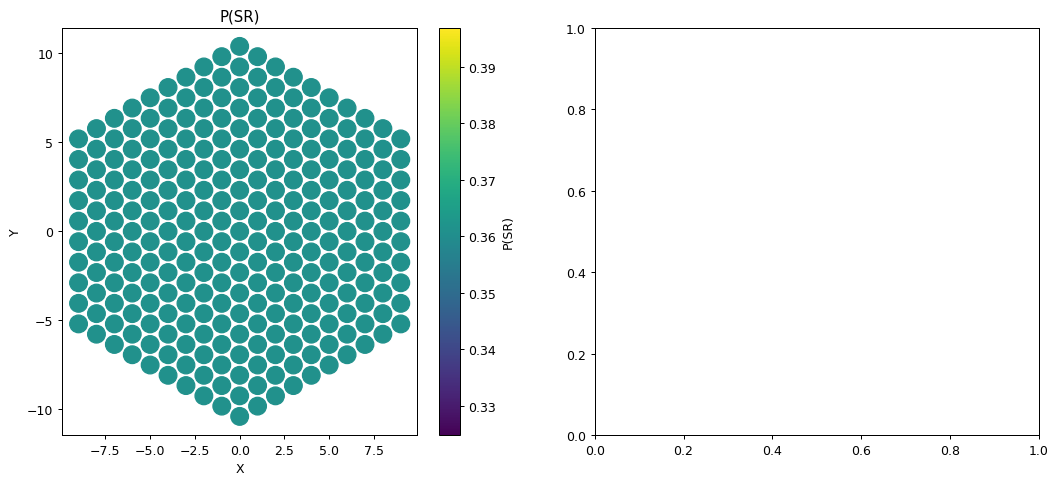

In [382]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(p_sr[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("P(SR)")
plt.colorbar(im, label="P(SR)",ax = axs[0])


In [377]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["PSR"], df3[df3["distance_group"]==True]["PSR"]))

Computing non parametric ANOVA on trial...


ValueError: All numbers are identical in kruskal

#### Spatial patterns of similarity of SR and MF to behavior

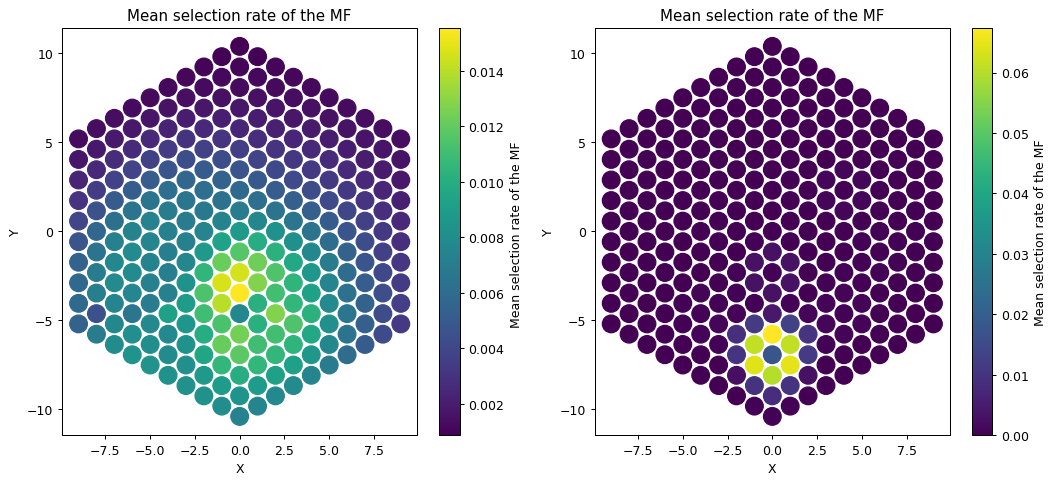

In [383]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varmf[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Variance in the MF actions values")
plt.colorbar(im, label="Variance in the MF actions values",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varsr[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Variance in the SR actions values")
plt.colorbar(im, label="Variance in the SR actions values",ax = axs[1])


In [92]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["varmf"], df3[df3["distance_group"]==True]["varmf"]))


Computing non parametric ANOVA on trial...
KruskalResult(statistic=25.63617952765111, pvalue=4.122373519510248e-07)


In [93]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["varsr"], df3[df3["distance_group"]==True]["varsr"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.808823529411825, pvalue=3.67645923668674e-13)


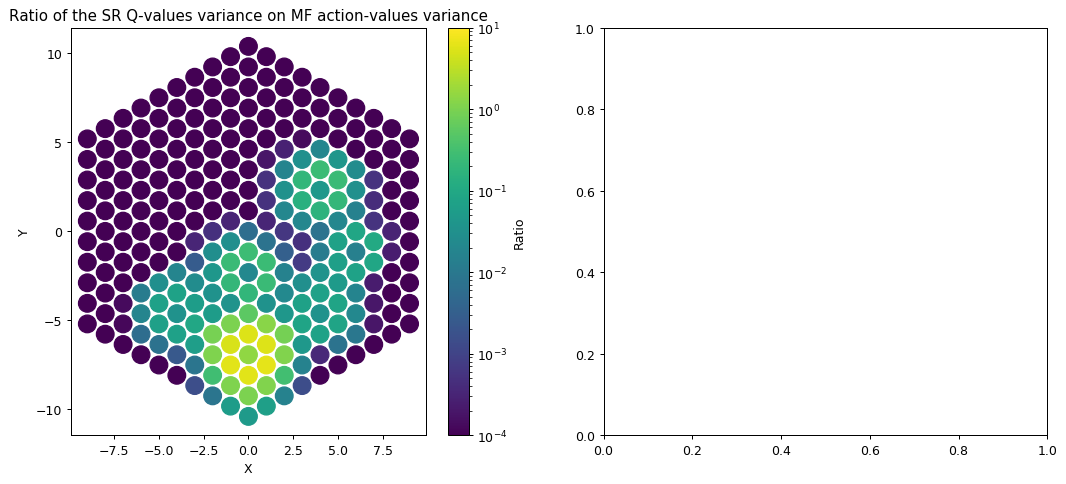

In [408]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varsr[cpt]/varmf[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm( 10, 0.0001))
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Ratio of the SR Q-values variance on MF action-values variance")
plt.colorbar(im, label="Ratio",ax = axs[0])



In [80]:
from scipy import stats
df3["difvar"] = df3["varsr"]/df3["varmf"]
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["difvar"], df3[df3["distance_group"]==True]["difvar"]))


Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.808823529411825, pvalue=3.67645923668674e-13)


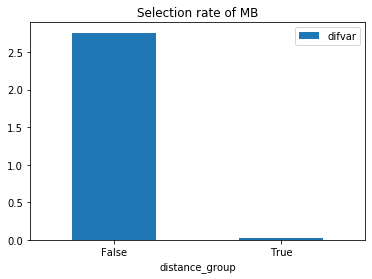

In [81]:
df3=df3.groupby(by=["distance_group"]).mean()
axes = df3[["difvar"]].plot.bar(title="Selection rate of MB", rot=0)

In [378]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["varmf"], df3[df3["distance_group"]==True]["varmf"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=36.74661518335272, pvalue=1.3452398144904819e-09)


In [379]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["varsr"], df3[df3["distance_group"]==True]["varsr"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.28073861123403, pvalue=4.810699347842461e-13)


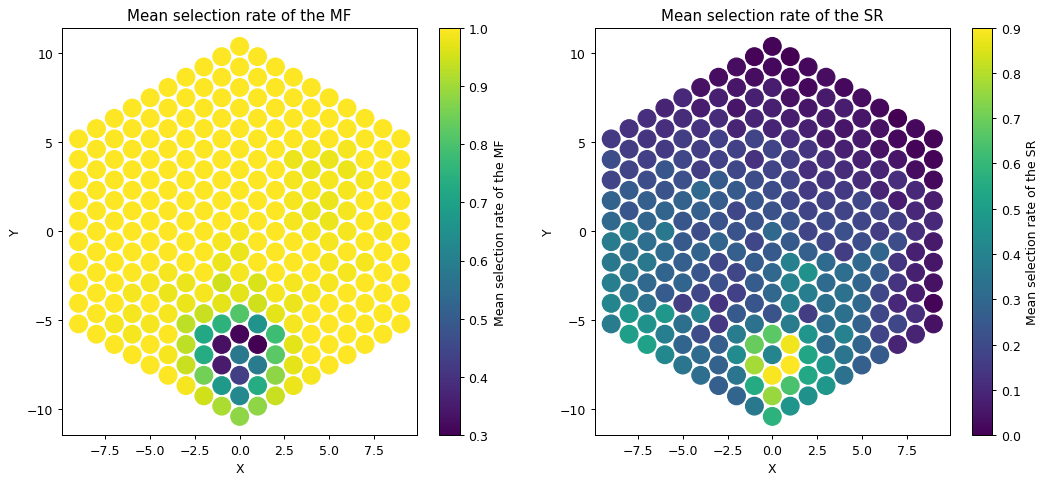

In [384]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(prevaMF[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Mean selection rate of the MF")
plt.colorbar(im, label="Mean selection rate of the MF",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(prevaSR[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Mean selection rate of the SR")
plt.colorbar(im, label="Mean selection rate of the SR",ax = axs[1])


In [380]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaMF"], df3[df3["distance_group"]==True]["prevaMF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=77.10606462585704, pvalue=1.6201904747279406e-18)


In [381]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaSR"], df3[df3["distance_group"]==True]["prevaSR"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=42.72190479413754, pvalue=6.310170378907093e-11)


In [94]:
_,_,_,_,p_sr, prevaMF, prevaSR, varmf, varsr = get_mean_preferred_dirs(agents, 48, 0)

In [60]:
df3 = df.groupby(by=["state"]).mean()
df3 = df3.reset_index()
df3 = df3["state"]
df3=df3.reset_index()

In [61]:
df3["distance"] = df3.apply(lambda row: calculateDistance(coords[126], coords[row.state]), axis=1)
df3["distance_group"] = df3.apply(lambda row: row.distance > 3, axis=1)

In [62]:
df3["PSR"] = p_sr
df3["prevaMF"] = prevaMF
df3["prevaSR"] = prevaSR
df3["varmf"] = varmf
df3["varsr"] = varsr

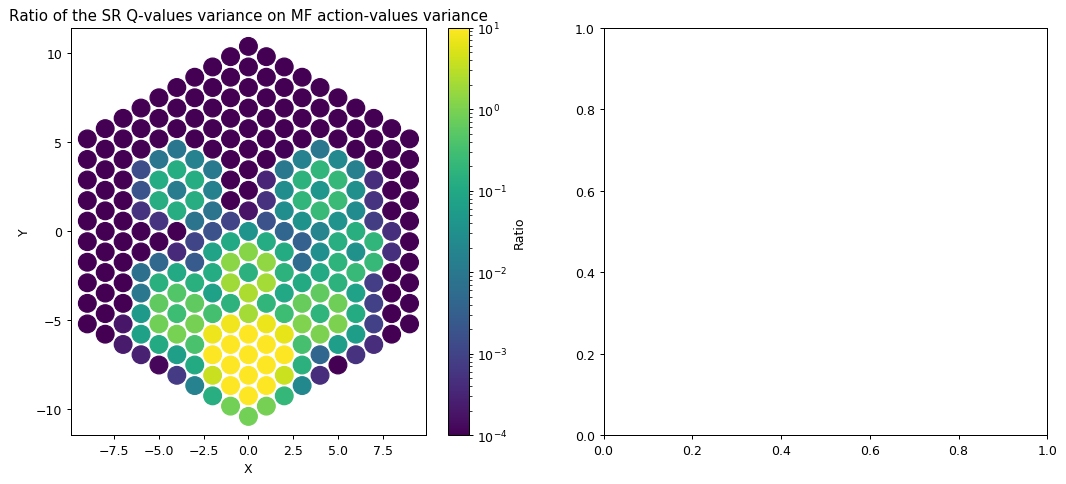

In [30]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varsr[cpt]/varmf[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm( 10, 0.0001))
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Ratio of the SR Q-values variance on MF action-values variance")
plt.colorbar(im, label="Ratio",ax = axs[0])



In [64]:
from scipy import stats
df3["difvar"] = df3["varsr"]/df3["varmf"]
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["difvar"], df3[df3["distance_group"]==True]["difvar"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.76471509656494, pvalue=3.7599574113354016e-13)


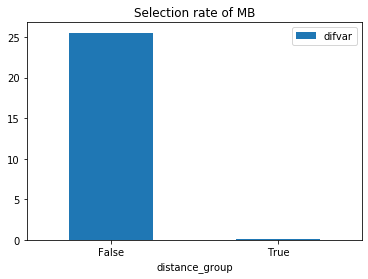

In [65]:
df3=df3.groupby(by=["distance_group"]).mean()
axes = df3[["difvar"]].plot.bar(title="Selection rate of MB", rot=0)

In [66]:
df3 = df.groupby(by=["state"]).mean()
df3 = df3.reset_index()
df3 = df3["state"]
df3=df3.reset_index()

In [67]:
df3["distance"] = df3.apply(lambda row: calculateDistance(coords[48], coords[row.state]), axis=1)
df3["distance_group"] = df3.apply(lambda row: row.distance > 3, axis=1)

In [68]:
df3["PSR"] = p_sr
df3["prevaMF"] = prevaMF
df3["prevaSR"] = prevaSR
df3["varmf"] = varmf
df3["varsr"] = varsr

In [69]:
from scipy import stats
df3["difvar"] = df3["varsr"]/df3["varmf"]
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaMF"], df3[df3["distance_group"]==True]["prevaMF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=6.2719761812504435, pvalue=0.012266226271347241)


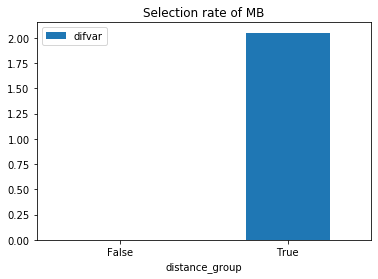

In [70]:
df3=df3.groupby(by=["distance_group"]).mean()
axes = df3[["difvar"]].plot.bar(title="Selection rate of MB", rot=0)

In [96]:
df3 = df.groupby(by=["state"]).mean()
df3 = df3.reset_index()
df3 = df3["state"]
df3=df3.reset_index()

df3["distance"] = df3.apply(lambda row: calculateDistance(coords[48], coords[row.state]), axis=1)
df3["distance_group"] = df3.apply(lambda row: row.distance > 3, axis=1)

df3["PSR"] = p_sr
df3["prevaMF"] = prevaMF
df3["prevaSR"] = prevaSR
df3["varmf"] = varmf
df3["varsr"] = varsr

In [98]:
from scipy import stats
df3["difvar"] = df3["varsr"]/df3["varmf"]
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaMF"], df3[df3["distance_group"]==True]["prevaMF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=7.433363706147856, pvalue=0.0064025553236287955)


Text(0.5, 1.0, 'Variance Q-SR / Variance Q-MF')

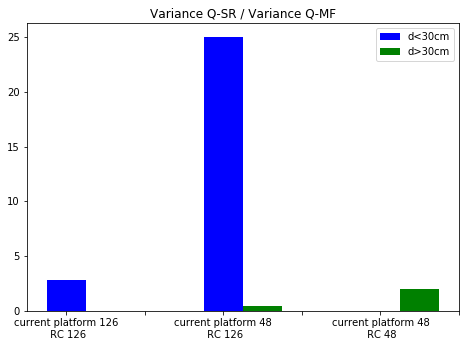

In [100]:
import numpy as np
import matplotlib.pyplot as plt
data = [[2.8, 25., 0.],
[0.05, 0.5, 2.],]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.set_xticklabels(['G1', 'current platform 126\n RC 126', '', 'current platform 48\n RC 126', '', "current platform 48\n RC 48"])
ax.legend(labels=['d<30cm', 'd>30cm'])
ax.set_title("Variance Q-SR / Variance Q-MF")

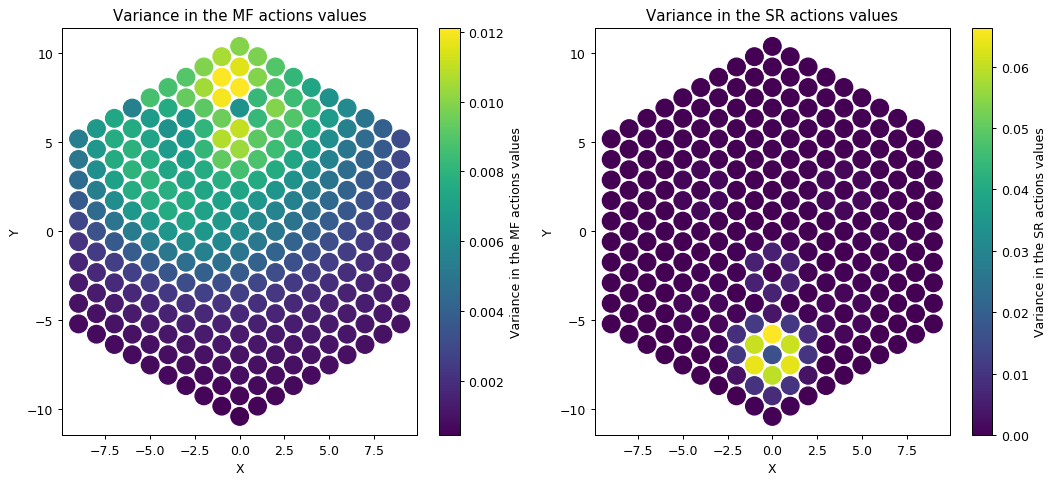

In [31]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varmf[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Variance in the MF actions values")
plt.colorbar(im, label="Variance in the MF actions values",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varsr[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Variance in the SR actions values")
plt.colorbar(im, label="Variance in the SR actions values",ax = axs[1])


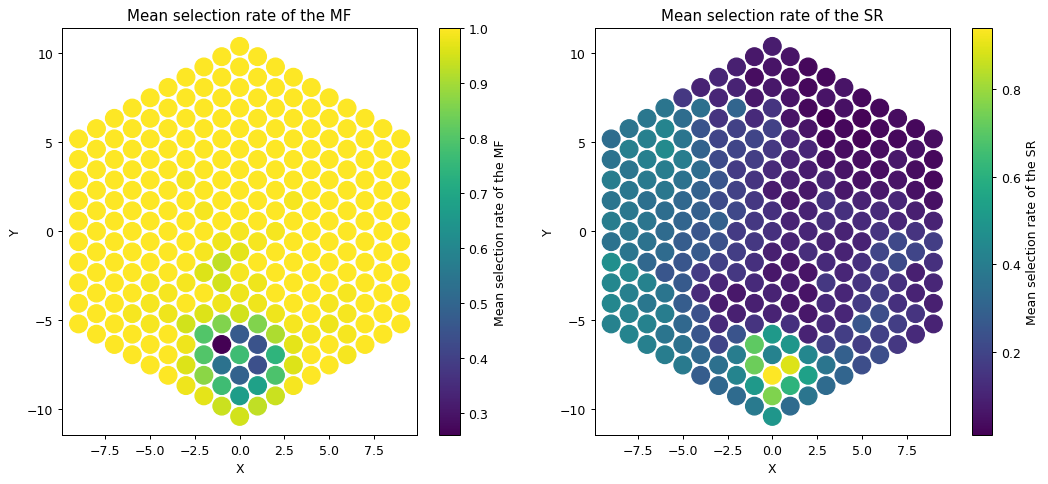

In [32]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(prevaMF[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Mean selection rate of the MF")
plt.colorbar(im, label="Mean selection rate of the MF",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(prevaSR[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Mean selection rate of the SR")
plt.colorbar(im, label="Mean selection rate of the SR",ax = axs[1])


## Rodrigo - Normal model

In [74]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_agents = 100
env_params.init_sr = "zero"
env_params.landmark_dist = 0
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.127
ag_params.q_lr = 0.043
ag_params.inv_temp = 22
ag_params.gamma = 0.867
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.01
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [75]:
from utils import get_coords
coords = get_coords()

In [76]:
from rodrigo_protocol import create_path_rodrigo
path = create_path_rodrigo(env_params, ag_params)

In [77]:
df = create_df(path, 100)

([<matplotlib.axis.XTick at 0x1e400531c88>,
 <a list of 14 Text xticklabel objects>)

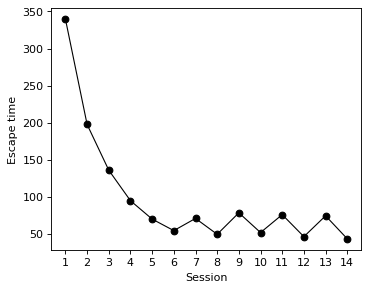

In [78]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby("session").mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["escape time"].plot(color="black", xlabel="Session", ylabel="Escape time", linewidth=1., marker="o")

df4 = df4.groupby("session").mean()
plt.xticks(range(1,15))



In [79]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="first"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     500.7
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           2.15e-72
Time:                        12:56:07   Log-Likelihood:                -2292.4
No. Observations:                 400   AIC:                             4589.
Df Residuals:                     398   BIC:                             4597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3140      6.257     44.803      0.000     268.014     292.614
session      -74.8354      3.344    -22.377      0.000     -81.410     -68.261
==============================================================================
Omnibus:                        1.433   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                1.521
Skew:                           0.135   Prob(JB):                        0.468
Kurtosis:                       2.866   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
# LINEAR REGRESSION ON ESCAPE TIME SECOND STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.022
Date:                Mon, 13 Dec 2021   Prob (F-statistic):             0.0452
Time:                        12:56:09   Log-Likelihood:                -4810.3
No. Observations:                1000   AIC:                             9625.
Df Residuals:                     998   BIC:                             9634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.4485      2.031     28.280      0.000      53.462      61.435
session       -0.6566      0.327     -2.006      0.045      -1.299      -0.014
==============================================================================
Omnibus:                      837.779   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26095.589
Skew:                           3.678   Prob(JB):                         0.00
Kurtosis:                      26.920   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

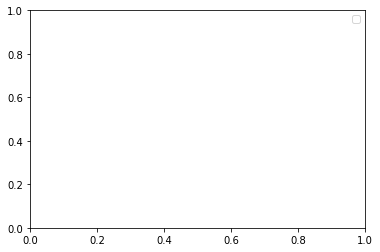

In [81]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

list_of_dataframes = []
for ang in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-ang), df3["angle"]==str(ang)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)
    df2["angle"] = abs(int(ang))

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])


    
    df2["previous_coord"] = df2["state"]
    df2["has_reached_prox"] = 0
    for i in range(100):
        print(i)
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
            df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
    #         if  df2.loc[ilo1, "has_reached_prox"] == 2:
    #             df2.loc[ilo2, "has_reached_prox"] = 2
    list_of_dataframes.append(df2)
df12 = pd.concat(list_of_dataframes)


In [92]:
def is_prox(previous_coord, coord, prox_x, prox_y):
    return calculateDistance(coords[previous_coord], (prox_x, prox_y)) >= calculateDistance(coords[coord], (prox_x, prox_y))

In [93]:
#df12["exploration_MB"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df12["distal_MF"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
df12["proximal_MF"] = df12.apply(lambda row: is_prox(row.previous_coord, row.state, row.proximal_posx, row.proximal_posy), axis=1)

In [94]:
def get_strategies(proxi_MF):
    if proxi_MF:
        return "toward proximal"
    else:
        return "toward distal"
    
df12["Strategies"] = df12.apply(lambda row: get_strategies(row.proximal_MF), axis=1)

In [95]:
data2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["has_reached_prox", "Strategies", "angle"]).count()
data2 = data2["time"]/25100


In [96]:
data3=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data3 = data3["time"]/25100


In [97]:
data4=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data4 = data4["time"]/25100

In [98]:
data2 = data2.reset_index()
data2 = data2[data2["has_reached_prox"]==0]
data2 = data2.set_index(["angle", "Strategies"], drop=True).time

In [99]:
data3 = data3.reset_index()
data3 = data3[data3["has_reached_prox"]==1]
data3 = data3.set_index(["angle", "Strategies"], drop=True).time

In [100]:
data4 = data4.reset_index()
data4 = data4[data4["has_reached_prox"]==2]
data4 = data4.set_index(["angle", "Strategies"], drop=True).time

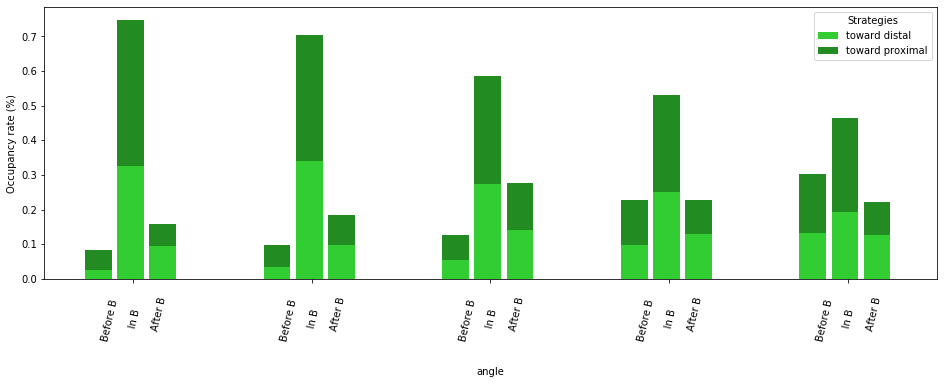

In [101]:
fig, ax = plt.subplots(figsize=(16,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)


data2.unstack().plot(kind='bar', position=1.8, ax=ax, legend=False,stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data3.unstack().plot(kind='bar', position=0.6, ax=ax, legend=False,stacked=True,width=0.15,color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])

ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=77)
ax.set_ylabel("Occupancy rate (%)")
plt.xlim((-0.5, len(data4)/2-0.5));

Proximal_MF

Text(0, 0.5, 'Occupancy rate (%)')

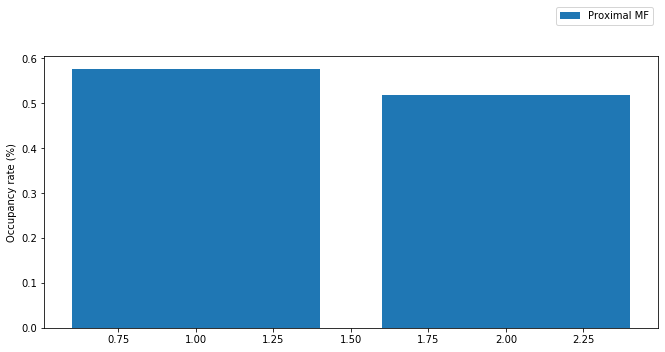

In [102]:
data36=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()
data36 = data36["proximal_MF"]
data36 = data36.reset_index()

fig, ax = plt.subplots(figsize=(11,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)
plt.bar(x=[1,2], height=[data36[data36["time"]<50]["proximal_MF"].mean(),data36[data36["time"]>=200]["proximal_MF"].mean()])
#data36["arbitrator_choice"].plot(kind='bar', ax=ax)
#data3.unstack().plot(kind='bar', position=0.6, ax=ax, stacked=True,width=0.15)
#data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15)
ax.legend(labels=['Proximal MF'], bbox_to_anchor=(1., 1.2))
#ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=70)
ax.set_ylabel("Occupancy rate (%)")
#plt.xlim((-0.5, len(data36)-0.5));

In [103]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(data36[data36["time"]<50]["proximal_MF"], data36[data36["time"]>200]["proximal_MF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=41.31914680749116, pvalue=1.292962015254746e-10)


Evolution of MF weights

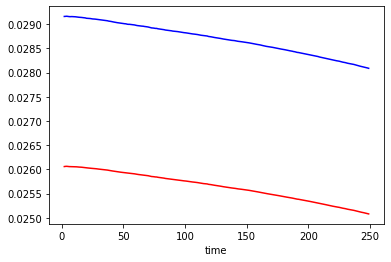

In [104]:
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_prox_mean"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_dist_mean"].plot(color="b")

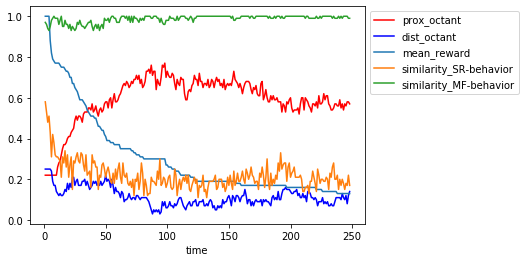

In [105]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt
df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-90", df3["angle"]=="90"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
df2 = df2.groupby("time").mean()
df2["isinoctant_proximal"][1:249].plot(color="r")
df2["isinoctant_distal"][1:249].plot(color="b")
df2["rew_func_sum"][1:249].plot()
df2["Qcombsr"][1:249].plot()
df2["Qcombmf"][1:249].plot()
plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

MF ENTROPY NEAR DISTAL/PROXIMAL

In [106]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-180", df3["angle"]=="180"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)


In [107]:
from scipy.stats import entropy
df2["entro_sr"] = df2.apply(lambda row: entropy(np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5])), axis=1)
df2["entro_mf"] = df2.apply(lambda row: entropy(np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5])), axis=1)
df2["var_sr"] = df2.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df2["var_mf"] = df2.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)
df7 = df2.groupby("state").mean()

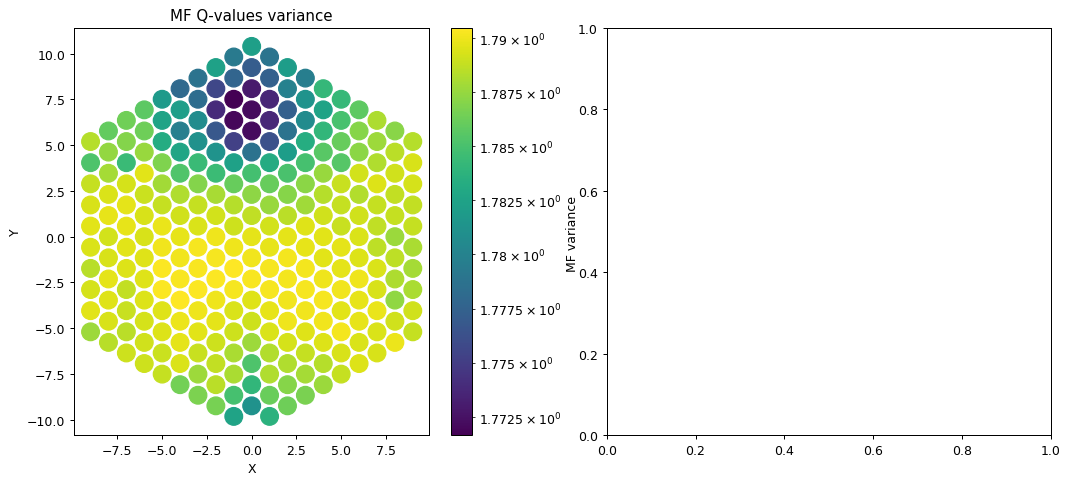

In [108]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["entro_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z,norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


## Rodrigo - HPC lesioned model

In [39]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_agents = 100
env_params.init_sr = "zero"
env_params.landmark_dist = 0
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.1271
ag_params.q_lr = 0.043
ag_params.inv_temp = 22
ag_params.gamma = 0.867
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.01
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [40]:
from utils import get_coords
coords = get_coords()

In [41]:
from rodrigo_protocol import create_path_rodrigo
path = create_path_rodrigo(env_params, ag_params)

In [42]:
df = create_df(path, 100)

([<matplotlib.axis.XTick at 0x1e40054c408>,
 <a list of 14 Text xticklabel objects>)

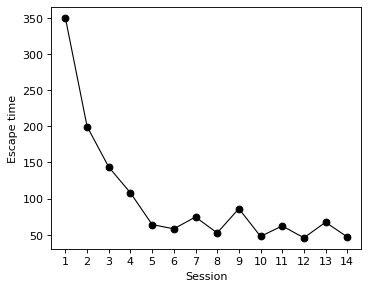

In [43]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby("session").mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["escape time"].plot(color="black", xlabel="Session", ylabel="Escape time", linewidth=1., marker="o")

df4 = df4.groupby("session").mean()
plt.xticks(range(1,15))



In [44]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="first"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     481.0
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           1.79e-70
Time:                        11:50:29   Log-Likelihood:                -2307.6
No. Observations:                 400   AIC:                             4619.
Df Residuals:                     398   BIC:                             4627.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        286.9916      6.499     44.161      0.000     274.215     299.768
session      -76.1866      3.474    -21.932      0.000     -83.016     -69.357
==============================================================================
Omnibus:                        7.274   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.398
Skew:                           0.333   Prob(JB):                       0.0247
Kurtosis:                       2.963   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# LINEAR REGRESSION ON ESCAPE TIME SECOND STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.194
Date:                Mon, 13 Dec 2021   Prob (F-statistic):            0.00429
Time:                        11:50:30   Log-Likelihood:                -4739.5
No. Observations:                1000   AIC:                             9483.
Df Residuals:                     998   BIC:                             9493.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.6342      1.892     30.455      0.000      53.921      61.348
session       -0.8730      0.305     -2.863      0.004      -1.472      -0.275
==============================================================================
Omnibus:                      779.279   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19848.426
Skew:                           3.363   Prob(JB):                         0.00
Kurtosis:                      23.764   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

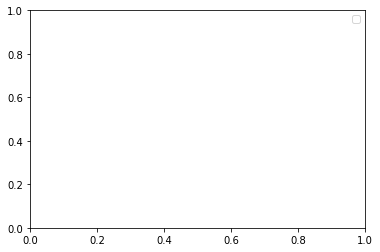

In [46]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

list_of_dataframes = []
for ang in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-ang), df3["angle"]==str(ang)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)
    df2["angle"] = abs(int(ang))

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])


    
    df2["previous_coord"] = df2["state"]
    df2["has_reached_prox"] = 0
    for i in range(100):
        print(i)
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
            df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
    #         if  df2.loc[ilo1, "has_reached_prox"] == 2:
    #             df2.loc[ilo2, "has_reached_prox"] = 2
    list_of_dataframes.append(df2)
df12 = pd.concat(list_of_dataframes)


In [47]:
def is_prox(previous_coord, coord, prox_x, prox_y):
    return calculateDistance(coords[previous_coord], (prox_x, prox_y)) >= calculateDistance(coords[coord], (prox_x, prox_y))

In [48]:
#df12["exploration_MB"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df12["distal_MF"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
df12["proximal_MF"] = df12.apply(lambda row: is_prox(row.previous_coord, row.state, row.proximal_posx, row.proximal_posy), axis=1)

In [49]:
def get_strategies(proxi_MF):
    if proxi_MF:
        return "toward proximal"
    else:
        return "toward distal"
    
df12["Strategies"] = df12.apply(lambda row: get_strategies(row.proximal_MF), axis=1)

In [67]:
data2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["has_reached_prox", "Strategies", "angle"]).count()
data2 = data2["time"]/25100


In [68]:
data3=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data3 = data3["time"]/25100


In [69]:
data4=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data4 = data4["time"]/25100

In [70]:
data2 = data2.reset_index()
data2 = data2[data2["has_reached_prox"]==0]
data2 = data2.set_index(["angle", "Strategies"], drop=True).time

In [71]:
data3 = data3.reset_index()
data3 = data3[data3["has_reached_prox"]==1]
data3 = data3.set_index(["angle", "Strategies"], drop=True).time

In [72]:
data4 = data4.reset_index()
data4 = data4[data4["has_reached_prox"]==2]
data4 = data4.set_index(["angle", "Strategies"], drop=True).time

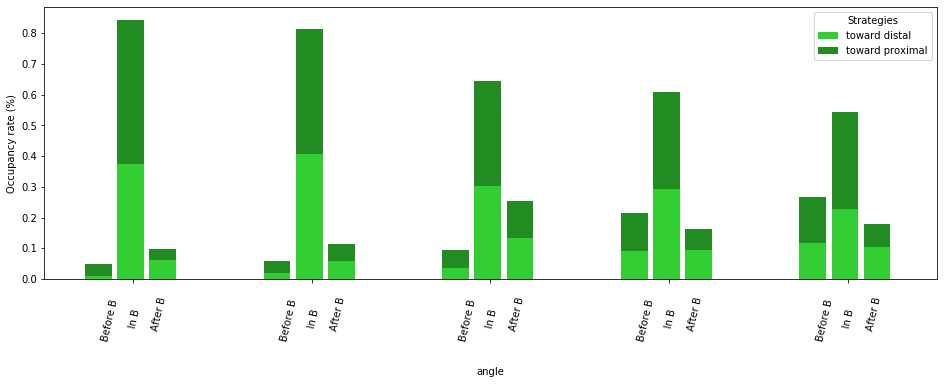

In [73]:
fig, ax = plt.subplots(figsize=(16,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)


data2.unstack().plot(kind='bar', position=1.8, ax=ax, legend=False,stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data3.unstack().plot(kind='bar', position=0.6, ax=ax, legend=False,stacked=True,width=0.15,color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])

ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=77)
ax.set_ylabel("Occupancy rate (%)")
plt.xlim((-0.5, len(data4)/2-0.5));

Proximal_MF

Text(0, 0.5, 'Occupancy rate (%)')

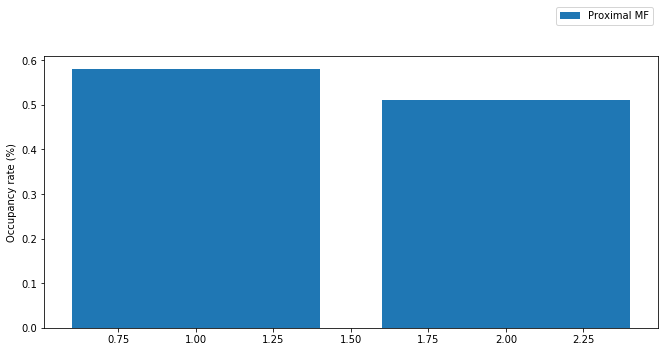

In [57]:
data36=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()
data36 = data36["proximal_MF"]
data36 = data36.reset_index()

fig, ax = plt.subplots(figsize=(11,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)
plt.bar(x=[1,2], height=[data36[data36["time"]<50]["proximal_MF"].mean(),data36[data36["time"]>=200]["proximal_MF"].mean()])
#data36["arbitrator_choice"].plot(kind='bar', ax=ax)
#data3.unstack().plot(kind='bar', position=0.6, ax=ax, stacked=True,width=0.15)
#data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15)
ax.legend(labels=['Proximal MF'], bbox_to_anchor=(1., 1.2))
#ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=70)
ax.set_ylabel("Occupancy rate (%)")
#plt.xlim((-0.5, len(data36)-0.5));

In [58]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(data36[data36["time"]<50]["proximal_MF"], data36[data36["time"]>200]["proximal_MF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=36.62986657156363, pvalue=1.4282656440369446e-09)


Evolution of MF weights

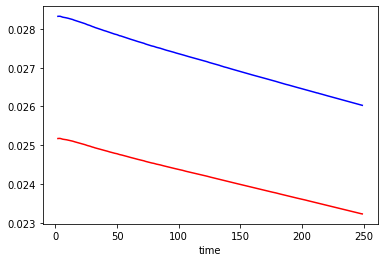

In [59]:
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_prox_mean"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_dist_mean"].plot(color="b")

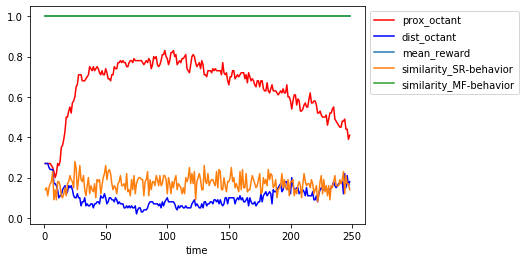

In [60]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt
df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-90", df3["angle"]=="90"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
df2 = df2.groupby("time").mean()
df2["isinoctant_proximal"][1:249].plot(color="r")
df2["isinoctant_distal"][1:249].plot(color="b")
df2["rew_func_sum"][1:249].plot()
df2["Qcombsr"][1:249].plot()
df2["Qcombmf"][1:249].plot()
plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

MF ENTROPY NEAR DISTAL/PROXIMAL

In [61]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-180", df3["angle"]=="180"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)


In [62]:
from scipy.stats import entropy
df2["entro_sr"] = df2.apply(lambda row: entropy(np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5])), axis=1)
df2["entro_mf"] = df2.apply(lambda row: entropy(np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5])), axis=1)
df2["var_sr"] = df2.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df2["var_mf"] = df2.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)
df7 = df2.groupby("state").mean()

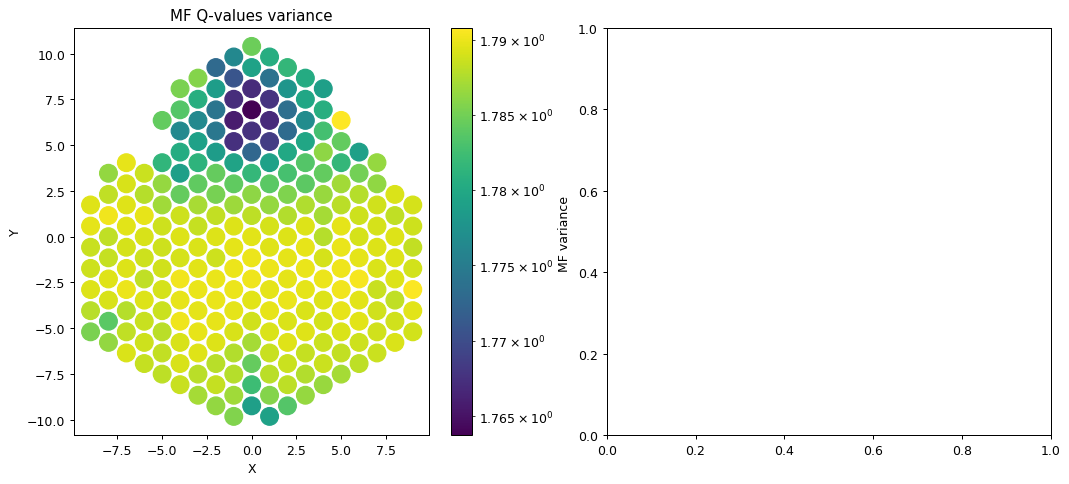

In [63]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["entro_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z,norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


## Rodrigo - HPC lesioned  / no learning model

In [110]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_agents = 103
env_params.init_sr = "zero"
env_params.landmark_dist = 0
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.1271
ag_params.q_lr = 0.043
ag_params.inv_temp = 22
ag_params.gamma = 0.867
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.01
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [111]:
from utils import get_coords
coords = get_coords()

In [112]:
from rodrigo_protocol import create_path_rodrigo
path = create_path_rodrigo(env_params, ag_params)

In [115]:
df = create_df(path, 103)

([<matplotlib.axis.XTick at 0x1e40072e5c8>,
 <a list of 14 Text xticklabel objects>)

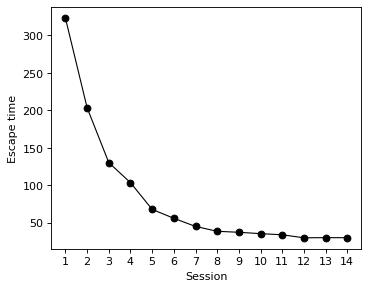

In [116]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby("session").mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["escape time"].plot(color="black", xlabel="Session", ylabel="Escape time", linewidth=1., marker="o")

df4 = df4.groupby("session").mean()
plt.xticks(range(1,15))



In [117]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="first"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     479.5
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           6.01e-71
Time:                        13:11:35   Log-Likelihood:                -2352.2
No. Observations:                 412   AIC:                             4708.
Df Residuals:                     410   BIC:                             4716.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        269.9379      6.031     44.759      0.000     258.082     281.793
session      -70.5872      3.224    -21.896      0.000     -76.924     -64.250
==============================================================================
Omnibus:                       19.679   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.375
Skew:                           0.510   Prob(JB):                     2.28e-05
Kurtosis:                       3.454   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
# LINEAR REGRESSION ON ESCAPE TIME SECOND STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     358.6
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           7.71e-69
Time:                        13:11:37   Log-Likelihood:                -4230.3
No. Observations:                1030   AIC:                             8465.
Df Residuals:                    1028   BIC:                             8474.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.0022      0.991     54.508      0.000      52.058      55.946
session       -3.0237      0.160    -18.937      0.000      -3.337      -2.710
==============================================================================
Omnibus:                      552.373   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5211.523
Skew:                           2.287   Prob(JB):                         0.00
Kurtosis:                      13.025   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34

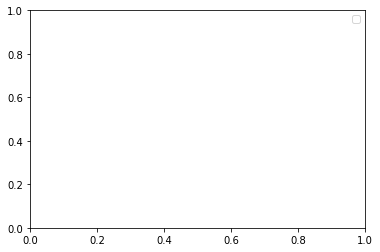

In [119]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

list_of_dataframes = []
for ang in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-ang), df3["angle"]==str(ang)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)
    df2["angle"] = abs(int(ang))

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])


    
    df2["previous_coord"] = df2["state"]
    df2["has_reached_prox"] = 0
    for i in range(103):
        print(i)
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
            df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
    #         if  df2.loc[ilo1, "has_reached_prox"] == 2:
    #             df2.loc[ilo2, "has_reached_prox"] = 2
    list_of_dataframes.append(df2)
df12 = pd.concat(list_of_dataframes)


In [120]:
def is_prox(previous_coord, coord, prox_x, prox_y):
    return calculateDistance(coords[previous_coord], (prox_x, prox_y)) >= calculateDistance(coords[coord], (prox_x, prox_y))

In [121]:
#df12["exploration_MB"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df12["distal_MF"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
df12["proximal_MF"] = df12.apply(lambda row: is_prox(row.previous_coord, row.state, row.proximal_posx, row.proximal_posy), axis=1)

In [122]:
def get_strategies(proxi_MF):
    if proxi_MF:
        return "toward proximal"
    else:
        return "toward distal"
    
df12["Strategies"] = df12.apply(lambda row: get_strategies(row.proximal_MF), axis=1)

In [123]:
data2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["has_reached_prox", "Strategies", "angle"]).count()
data2 = data2["time"]/25850


In [124]:
data3=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data3 = data3["time"]/25850


In [125]:
data4=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data4 = data4["time"]/25850

In [126]:
data2 = data2.reset_index()
data2 = data2[data2["has_reached_prox"]==0]
data2 = data2.set_index(["angle", "Strategies"], drop=True).time

In [127]:
data3 = data3.reset_index()
data3 = data3[data3["has_reached_prox"]==1]
data3 = data3.set_index(["angle", "Strategies"], drop=True).time

In [128]:
data4 = data4.reset_index()
data4 = data4[data4["has_reached_prox"]==2]
data4 = data4.set_index(["angle", "Strategies"], drop=True).time

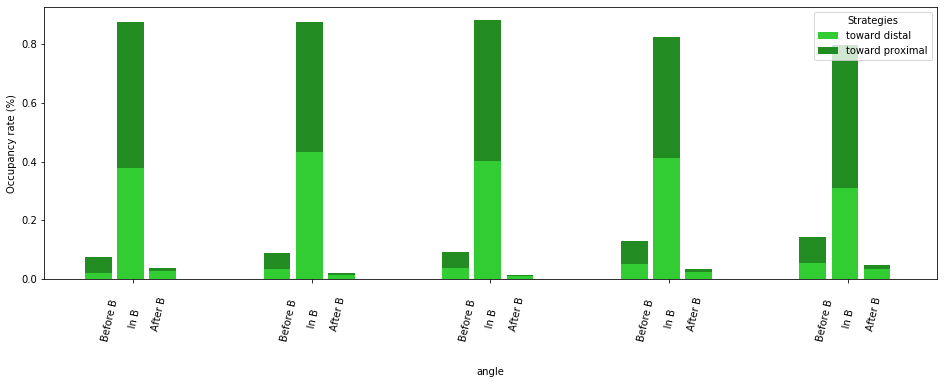

In [129]:
fig, ax = plt.subplots(figsize=(16,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)


data2.unstack().plot(kind='bar', position=1.8, ax=ax, legend=False,stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data3.unstack().plot(kind='bar', position=0.6, ax=ax, legend=False,stacked=True,width=0.15,color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])

ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=77)
ax.set_ylabel("Occupancy rate (%)")
plt.xlim((-0.5, len(data4)/2-0.5));

Proximal_MF

Text(0, 0.5, 'Occupancy rate (%)')

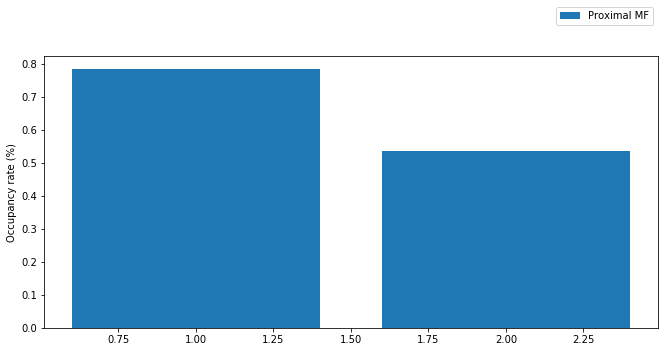

In [139]:
data36=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()
data36 = data36["proximal_MF"]
data36 = data36.reset_index()

fig, ax = plt.subplots(figsize=(11,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)
plt.bar(x=[1,2], height=[data36[data36["time"]<5]["proximal_MF"].mean(),data36[data36["time"]>=200]["proximal_MF"].mean()])
#data36["arbitrator_choice"].plot(kind='bar', ax=ax)
#data3.unstack().plot(kind='bar', position=0.6, ax=ax, stacked=True,width=0.15)
#data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15)
ax.legend(labels=['Proximal MF'], bbox_to_anchor=(1., 1.2))
#ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=70)
ax.set_ylabel("Occupancy rate (%)")
#plt.xlim((-0.5, len(data36)-0.5));

In [131]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(data36[data36["time"]<50]["proximal_MF"], data36[data36["time"]>200]["proximal_MF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=35.39934281301508, pvalue=2.6857749028768107e-09)


Evolution of MF weights

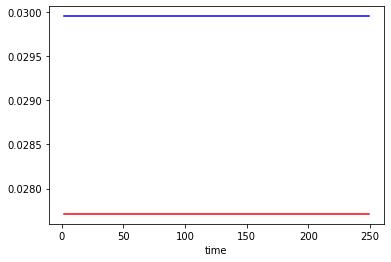

In [132]:
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_prox_mean"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_dist_mean"].plot(color="b")

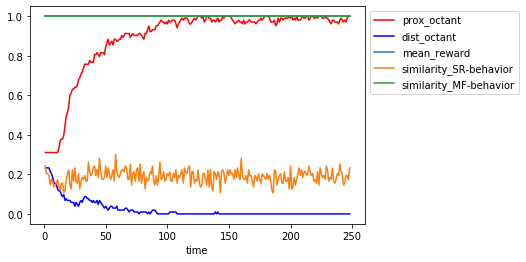

In [133]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt
df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-90", df3["angle"]=="90"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
df2 = df2.groupby("time").mean()
df2["isinoctant_proximal"][1:249].plot(color="r")
df2["isinoctant_distal"][1:249].plot(color="b")
df2["rew_func_sum"][1:249].plot()
df2["Qcombsr"][1:249].plot()
df2["Qcombmf"][1:249].plot()
plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

MF ENTROPY NEAR DISTAL/PROXIMAL

In [134]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-180", df3["angle"]=="180"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)


In [135]:
from scipy.stats import entropy
df2["entro_sr"] = df2.apply(lambda row: entropy(np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5])), axis=1)
df2["entro_mf"] = df2.apply(lambda row: entropy(np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5])), axis=1)
df2["var_sr"] = df2.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df2["var_mf"] = df2.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)
df7 = df2.groupby("state").mean()

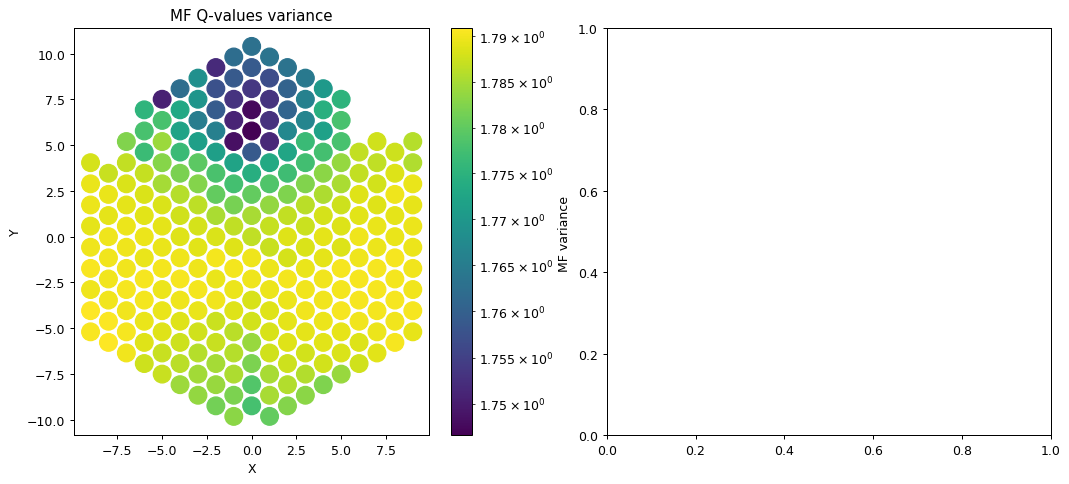

In [136]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["entro_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z,norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


In [143]:
df12.columns

Index(['time', 'agent', 'level_0', 'index', 'Unnamed: 0', 'state', 'P(SR)',
       'previous_platform', 'platform', 'rew_func_sum', 'Q_max', 'Qsr_max',
       'Qcombmf', 'Qcombsr', 'Qsr0', 'Qsr1', 'Qsr2', 'Qsr3', 'Qsr4', 'Qsr5',
       'Qmf0', 'Qmf1', 'Qmf2', 'Qmf3', 'Qmf4', 'Qmf5', 'Qcomb0', 'Qcomb1',
       'Qcomb2', 'Qcomb3', 'Qcomb4', 'Qcomb5', 'syn_prox_mean',
       'syn_dist_mean', 'trial', 'escape time', 'total trial', 'total time',
       'isinoctant_distal', 'isinoctant_proximal', 'proximal_posx',
       'proximal_posy', 'angle', 'previous_coord', 'has_reached_prox',
       'proximal_MF', 'Strategies'],
      dtype='object')

In [159]:
df11 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)]
df11 = df11[df11["angle"]==180].groupby("state")["has_reached_prox"].mean() 

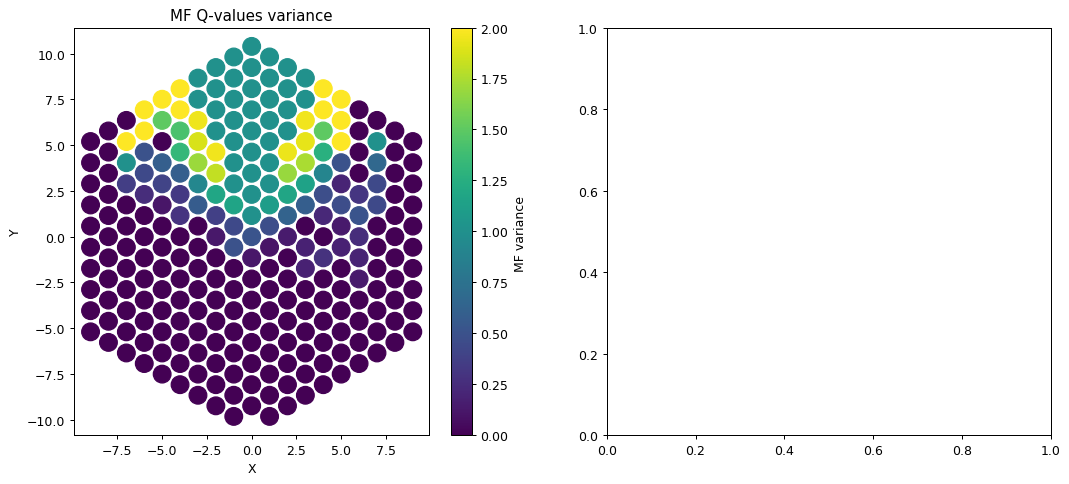

In [160]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df11[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


## Rodrigo - HPC lesioned  / no learning model

In [211]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_agents = 22
env_params.init_sr = "zero"
env_params.landmark_dist = 0
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.1271
ag_params.q_lr = 0.043
ag_params.inv_temp = 22
ag_params.gamma = 0.867
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.01
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [212]:
from utils import get_coords
coords = get_coords()

In [213]:
from rodrigo_protocol import create_path_rodrigo
path = create_path_rodrigo(env_params, ag_params)

In [214]:
df = create_df(path, 22)

([<matplotlib.axis.XTick at 0x1e401339748>,
 <a list of 14 Text xticklabel objects>)

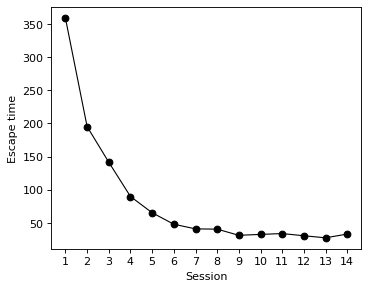

In [202]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby("session").mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["escape time"].plot(color="black", xlabel="Session", ylabel="Escape time", linewidth=1., marker="o")

df4 = df4.groupby("session").mean()
plt.xticks(range(1,15))



In [170]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="first"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     136.1
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           8.78e-19
Time:                        13:59:33   Log-Likelihood:                -449.94
No. Observations:                  80   AIC:                             903.9
Df Residuals:                      78   BIC:                             908.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        288.6642     12.702     22.726      0.000     263.377     313.952
session      -79.2204      6.789    -11.668      0.000     -92.737     -65.704
==============================================================================
Omnibus:                        0.506   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.776   Jarque-Bera (JB):                0.452
Skew:                           0.178   Prob(JB):                        0.798
Kurtosis:                       2.904   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [171]:
# LINEAR REGRESSION ON ESCAPE TIME SECOND STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     70.16
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           9.92e-15
Time:                        13:59:37   Log-Likelihood:                -822.64
No. Observations:                 200   AIC:                             1649.
Df Residuals:                     198   BIC:                             1656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.3822      2.271     23.503      0.000      48.903      57.861
session       -3.0662      0.366     -8.376      0.000      -3.788      -2.344
==============================================================================
Omnibus:                      137.266   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1386.093
Skew:                           2.515   Prob(JB):                    1.03e-301
Kurtosis:                      14.875   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


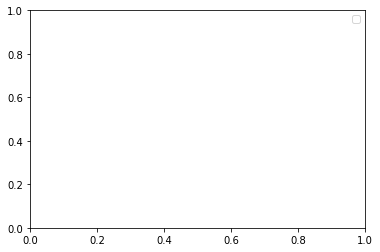

In [215]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

list_of_dataframes = []
for ang in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-ang), df3["angle"]==str(ang)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)
    df2["angle"] = abs(int(ang))

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])


    
    df2["previous_coord"] = df2["state"]
    df2["has_reached_prox"] = 0
    for i in range(22):
        print(i)
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
            df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
    #         if  df2.loc[ilo1, "has_reached_prox"] == 2:
    #             df2.loc[ilo2, "has_reached_prox"] = 2
    list_of_dataframes.append(df2)
df12 = pd.concat(list_of_dataframes)


In [120]:
def is_prox(previous_coord, coord, prox_x, prox_y):
    return calculateDistance(coords[previous_coord], (prox_x, prox_y)) >= calculateDistance(coords[coord], (prox_x, prox_y))

In [121]:
#df12["exploration_MB"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df12["distal_MF"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
df12["proximal_MF"] = df12.apply(lambda row: is_prox(row.previous_coord, row.state, row.proximal_posx, row.proximal_posy), axis=1)

In [122]:
def get_strategies(proxi_MF):
    if proxi_MF:
        return "toward proximal"
    else:
        return "toward distal"
    
df12["Strategies"] = df12.apply(lambda row: get_strategies(row.proximal_MF), axis=1)

In [123]:
data2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["has_reached_prox", "Strategies", "angle"]).count()
data2 = data2["time"]/25850


In [124]:
data3=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data3 = data3["time"]/25850


In [125]:
data4=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data4 = data4["time"]/25850

In [126]:
data2 = data2.reset_index()
data2 = data2[data2["has_reached_prox"]==0]
data2 = data2.set_index(["angle", "Strategies"], drop=True).time

In [127]:
data3 = data3.reset_index()
data3 = data3[data3["has_reached_prox"]==1]
data3 = data3.set_index(["angle", "Strategies"], drop=True).time

In [128]:
data4 = data4.reset_index()
data4 = data4[data4["has_reached_prox"]==2]
data4 = data4.set_index(["angle", "Strategies"], drop=True).time

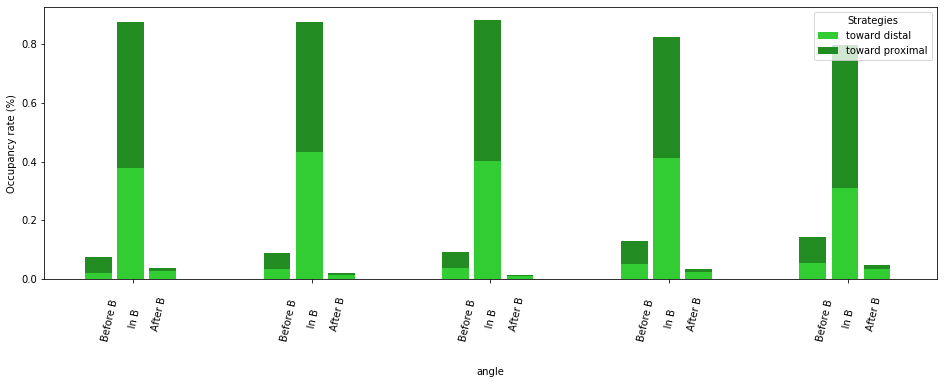

In [129]:
fig, ax = plt.subplots(figsize=(16,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)


data2.unstack().plot(kind='bar', position=1.8, ax=ax, legend=False,stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data3.unstack().plot(kind='bar', position=0.6, ax=ax, legend=False,stacked=True,width=0.15,color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])

ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=77)
ax.set_ylabel("Occupancy rate (%)")
plt.xlim((-0.5, len(data4)/2-0.5));

Proximal_MF

Text(0, 0.5, 'Occupancy rate (%)')

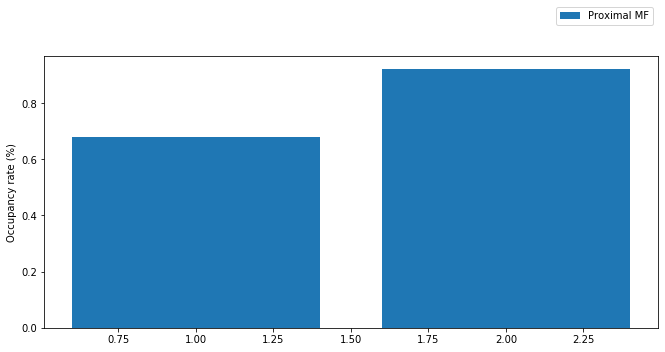

In [210]:
data36=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()
data36 = data36["Qcombprox"]
data36 = data36.reset_index()

fig, ax = plt.subplots(figsize=(11,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)
plt.bar(x=[1,2], height=[data36[data36["time"]<5]["Qcombprox"].mean(),data36[data36["time"]>=200]["Qcombprox"].mean()])
#data36["arbitrator_choice"].plot(kind='bar', ax=ax)
#data3.unstack().plot(kind='bar', position=0.6, ax=ax, stacked=True,width=0.15)
#data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15)
ax.legend(labels=['Proximal MF'], bbox_to_anchor=(1., 1.2))
#ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=70)
ax.set_ylabel("Occupancy rate (%)")
#plt.xlim((-0.5, len(data36)-0.5));

Text(0, 0.5, 'Occupancy rate (%)')

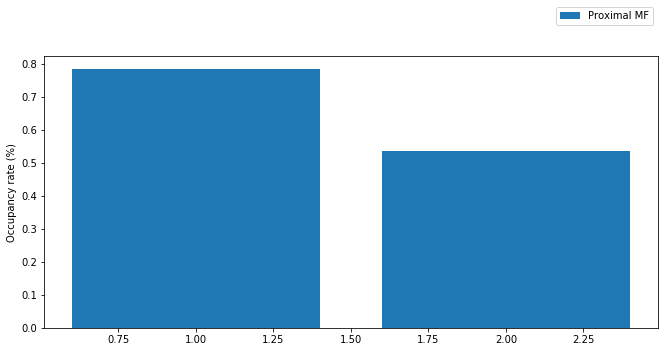

In [139]:
data36=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()
data36 = data36["proximal_MF"]
data36 = data36.reset_index()

fig, ax = plt.subplots(figsize=(11,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)
plt.bar(x=[1,2], height=[data36[data36["time"]<5]["proximal_MF"].mean(),data36[data36["time"]>=200]["proximal_MF"].mean()])
#data36["arbitrator_choice"].plot(kind='bar', ax=ax)
#data3.unstack().plot(kind='bar', position=0.6, ax=ax, stacked=True,width=0.15)
#data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15)
ax.legend(labels=['Proximal MF'], bbox_to_anchor=(1., 1.2))
#ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=70)
ax.set_ylabel("Occupancy rate (%)")
#plt.xlim((-0.5, len(data36)-0.5));

In [131]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(data36[data36["time"]<50]["proximal_MF"], data36[data36["time"]>200]["proximal_MF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=35.39934281301508, pvalue=2.6857749028768107e-09)


Evolution of MF weights

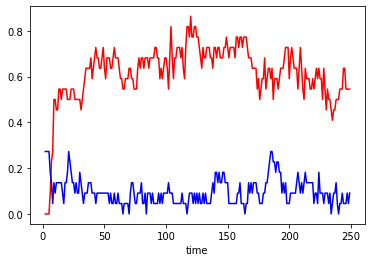

In [225]:
df12[np.logical_and(np.logical_and(df12["time"]>1, df12["time"]<250), df12["angle"]==135)].groupby("time").mean()["isinoctant_proximal"].plot(color="r")
df12[np.logical_and(np.logical_and(df12["time"]>1, df12["time"]<250), df12["angle"]==135)].groupby("time").mean()["isinoctant_distal"].plot(color="b")

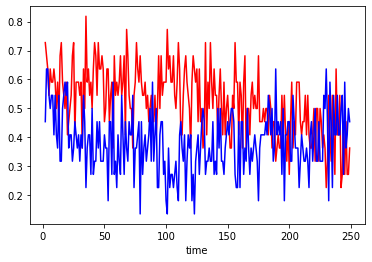

In [223]:
df12[np.logical_and(np.logical_and(df12["time"]>1, df12["time"]<250), df12["angle"]==135)].groupby("time").mean()["Qcombprox"].plot(color="r")
df12[np.logical_and(np.logical_and(df12["time"]>1, df12["time"]<250), df12["angle"]==135)].groupby("time").mean()["Qcombdist"].plot(color="b")

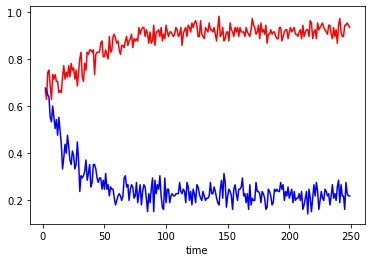

In [209]:
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["Qcombprox"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["Qcombdist"].plot(color="b")

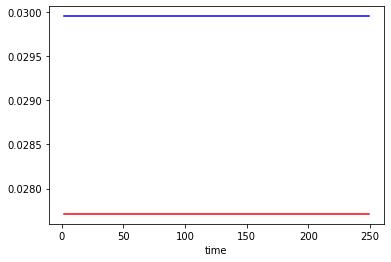

In [132]:
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_prox_mean"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_dist_mean"].plot(color="b")

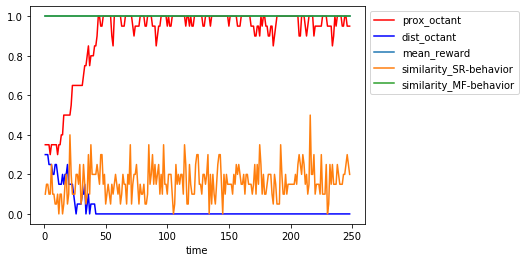

In [181]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt
df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-90", df3["angle"]=="90"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
df2 = df2.groupby("time").mean()
df2["isinoctant_proximal"][1:249].plot(color="r")
df2["isinoctant_distal"][1:249].plot(color="b")
df2["rew_func_sum"][1:249].plot()
df2["Qcombsr"][1:249].plot()
df2["Qcombmf"][1:249].plot()
plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

MF ENTROPY NEAR DISTAL/PROXIMAL

In [205]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-180", df3["angle"]=="180"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)


In [135]:
from scipy.stats import entropy
df2["entro_sr"] = df2.apply(lambda row: entropy(np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5])), axis=1)
df2["entro_mf"] = df2.apply(lambda row: entropy(np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5])), axis=1)
df2["var_sr"] = df2.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df2["var_mf"] = df2.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)
df7 = df2.groupby("state").mean()

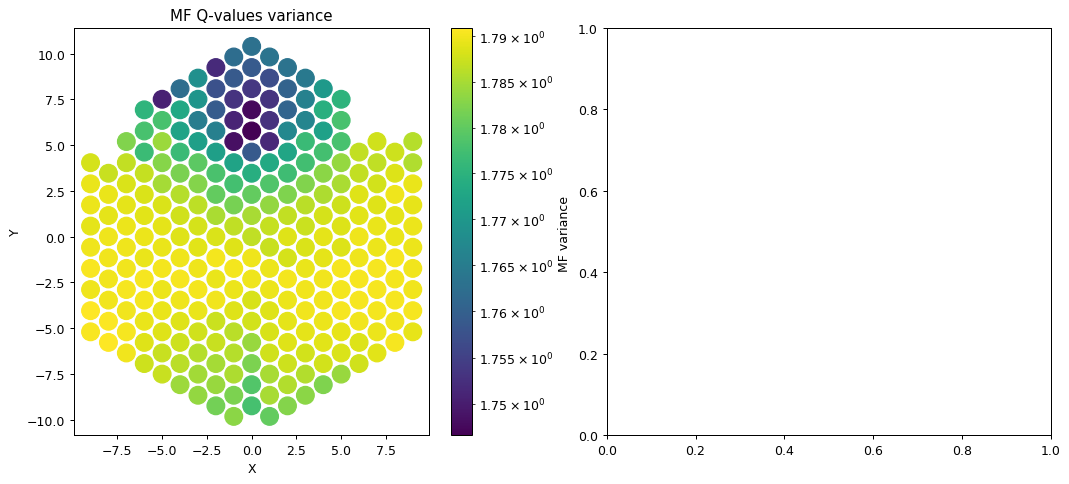

In [136]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["entro_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z,norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


In [143]:
df12.columns

Index(['time', 'agent', 'level_0', 'index', 'Unnamed: 0', 'state', 'P(SR)',
       'previous_platform', 'platform', 'rew_func_sum', 'Q_max', 'Qsr_max',
       'Qcombmf', 'Qcombsr', 'Qsr0', 'Qsr1', 'Qsr2', 'Qsr3', 'Qsr4', 'Qsr5',
       'Qmf0', 'Qmf1', 'Qmf2', 'Qmf3', 'Qmf4', 'Qmf5', 'Qcomb0', 'Qcomb1',
       'Qcomb2', 'Qcomb3', 'Qcomb4', 'Qcomb5', 'syn_prox_mean',
       'syn_dist_mean', 'trial', 'escape time', 'total trial', 'total time',
       'isinoctant_distal', 'isinoctant_proximal', 'proximal_posx',
       'proximal_posy', 'angle', 'previous_coord', 'has_reached_prox',
       'proximal_MF', 'Strategies'],
      dtype='object')

In [204]:
from scipy.stats import entropy
#df2["entro_sr"] = df2.apply(lambda row: entropy(np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5])), axis=1)
#df2["entro_mf"] = df2.apply(lambda row: entropy(np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5])), axis=1)
df2["var_dist"] = df2.apply(lambda row: np.array([row.Qprox0, row.Qdist1, row.Qdist2, row.Qdist3, row.Qdist4, row.Qdist5]).var(), axis=1)
df2["var_prox"] = df2.apply(lambda row: np.array([row.Qprox0, row.Qprox1, row.Qprox2, row.Qprox3, row.Qprox4, row.Qprox5]).var(), axis=1)
df7 = df2.groupby("state").mean()

In [176]:
df11 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)]
df11 = df11[df11["angle"]==180].groupby("state")["var_dist"].mean() 

KeyError: 'Column not found: var_dist'

In [185]:
df7

index   Unnamed: 0       time     P(SR)  previous_platform  \
state                                                                     
0      7547.500000  7547.500000  41.500000  0.265516               90.0   
1      7409.000000  7409.000000  99.666667  0.338003               90.0   
2      7353.000000  7353.000000  88.500000  0.330593               90.0   
3      7354.500000  7354.500000  90.000000  0.330593               90.0   
4      7917.000000  7917.000000  35.000000  0.222670               90.0   
...            ...          ...        ...       ...                ...   
266    7146.000000  7146.000000  16.000000  0.308363               90.0   
267    5251.666667  5251.666667  15.000000  0.460413               90.0   
268    6360.333333  6360.333333   6.833333  0.377516               90.0   
269    6074.000000  6074.000000   5.363636  0.392704               90.0   
270    6878.666667  6878.666667   1.888889  0.323594               90.0   

       platform  rew_func_sum     Q_max  Qsr_max   Qcombmf  ...  \
state                                                       ...   
0           NaN           1.0  0.560204      0.0  1.000000  ...   
1           NaN           1.0  0.557047      0.0  1.000000  ...   
2           NaN           1.0  0.589035      0.0  1.000000  ...   
3           NaN           1.0  0.581519      0.0  1.000000  ...   
4           NaN           1.0  0.500479      0.0  1.000000  ...   
...         ...           ...       ...      ...       ...  ...   
266         NaN           1.0  0.450705      0.0  1.000000  ...   
267         NaN           1.0  0.325472      0.0  1.000000  ...   
268         NaN           1.0  0.312453      0.0  1.000000  ...   
269         NaN           1.0  0.290559      0.0  1.000000  ...   
270         NaN           1.0  0.125769      0.0  0.444444  ...   

       syn_dist_mean  trial  escape time  total trial   total time      agent  \
state                                                                           
0           0.029464    8.0        250.0    90.000000  7547.500000   7.000000   
1           0.029572    8.0        250.0    90.000000  7409.000000  13.000000   
2           0.029594    8.0        250.0    90.000000  7353.000000  12.500000   
3           0.029594    8.0        250.0    90.000000  7354.500000  12.500000   
4           0.029270    8.0        250.0    90.000000  7917.000000   3.000000   
...              ...    ...          ...          ...          ...        ...   
266         0.029658    8.0        250.0    90.000000  7146.000000  11.000000   
267         0.029926    8.0        250.0    66.000000  5251.666667   3.666667   
268         0.029706    8.0        250.0    78.000000  6360.333333   6.500000   
269         0.029723    8.0        250.0    73.636364  6074.000000   4.090909   
270         0.029470    8.0        250.0    84.000000  6878.666667   5.222222   

       isinoctant_distal  isinoctant_proximal  var_dist  var_prox  
state                                                              
0                    0.0                  0.0  0.006314  0.003558  
1                    0.0                  0.0  0.001260  0.001260  
2                    0.0                  0.0  0.003028  0.002448  
3                    0.0                  1.0  0.003638  0.003668  
4                    0.0                  0.0  0.002088  0.002068  
...                  ...                  ...       ...       ...  
266                  0.0                  0.0  0.005007  0.000244  
267                  1.0                  0.0  0.001220  0.000226  
268                  1.0                  0.0  0.001486  0.000151  
269                  1.0                  0.0  0.001576  0.000166  
270                  1.0                  0.0  0.000779  0.000075  

[221 rows x 52 columns]

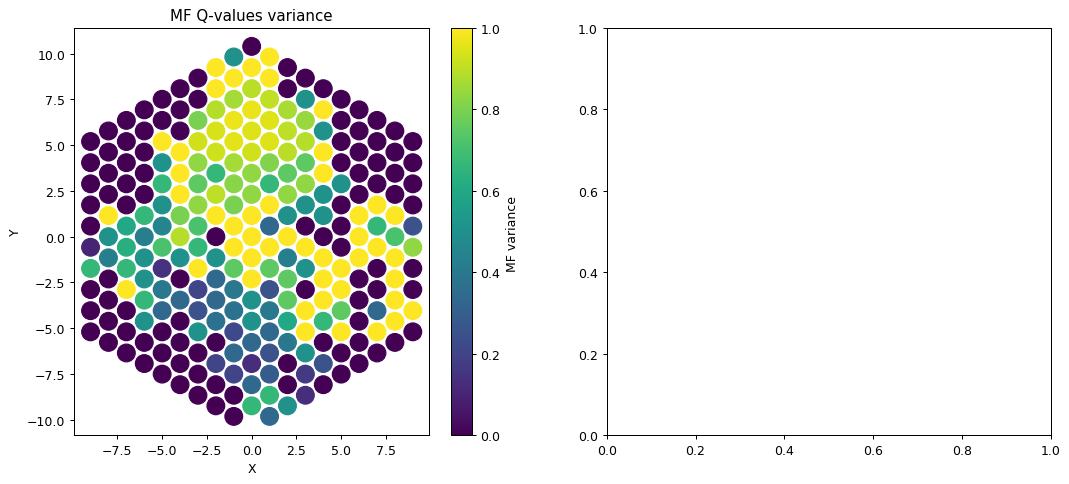

In [208]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["Qcombprox"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


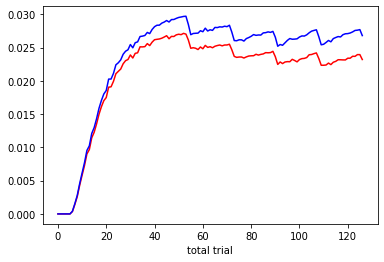

In [13]:
# WEIGHT OF THE SYNAPSES
from utils import isinoctant
from matplotlib import pyplot as plt
df3 = df.reset_index()
df2 = df3
df2 = df2.groupby("total trial").mean()
df2["syn_prox_mean"].plot(color="r")
df2["syn_dist_mean"].plot(color="b")

([<matplotlib.axis.XTick at 0x23106f38c48>,
 <a list of 14 Text xticklabel objects>)

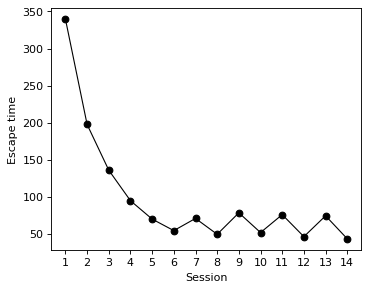

In [10]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby("session").mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["escape time"].plot(color="black", xlabel="Session", ylabel="Escape time", linewidth=1., marker="o")

df4 = df4.groupby("session").mean()
plt.xticks(range(1,15))



In [11]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="first"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     500.7
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.15e-72
Time:                        12:39:38   Log-Likelihood:                -2292.4
No. Observations:                 400   AIC:                             4589.
Df Residuals:                     398   BIC:                             4597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3140      6.257     44.803      0.000     268.014     292.614
session      -74.8354      3.344    -22.377      0.000     -81.410     -68.261
==============================================================================
Omnibus:                        1.433   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                1.521
Skew:                           0.135   Prob(JB):                        0.468
Kurtosis:                       2.866   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# LINEAR REGRESSION ON ESCAPE TIME SECOND STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.022
Date:                Mon, 06 Dec 2021   Prob (F-statistic):             0.0452
Time:                        12:39:42   Log-Likelihood:                -4810.3
No. Observations:                1000   AIC:                             9625.
Df Residuals:                     998   BIC:                             9634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.4485      2.031     28.280      0.000      53.462      61.435
session       -0.6566      0.327     -2.006      0.045      -1.299      -0.014
==============================================================================
Omnibus:                      837.779   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26095.589
Skew:                           3.678   Prob(JB):                         0.00
Kurtosis:                      26.920   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

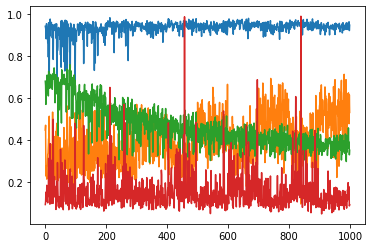

In [13]:
df2["Qcombmf"].plot()
df2["Qcombsr"].plot()
df2["P(SR)"].plot()
df4 = df[df["trial"] == 0]
df5 = df[df["trial"] == 3]
df4 = df4.groupby("session").mean()
df5 = df5.groupby("session").mean()
#df4["escape time"].plot()
#df5["escape time"].plot()
df2["lol"] = df5["escape time"] / df4["escape time"]
df2["escape time2"] = df2["escape time"]/350
df2["escape time2"].plot()
df2["lol"].plot()

In [14]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df2.index:
    try:
        z.append(df2["time"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z,norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Mean selection rate of the MF")
plt.colorbar(im, label="Mean selection rate of the MF",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df2.index:
    try:
        z.append(prevaSR[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Mean selection rate of the SR")
plt.colorbar(im, label="Mean selection rate of the SR",ax = axs[1])


KeyError: 271

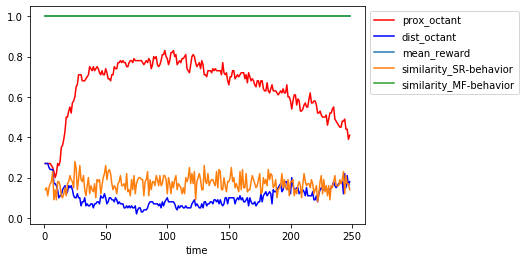

In [11]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt
df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-90", df3["angle"]=="90"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
df2 = df2.groupby("time").mean()
df2["isinoctant_proximal"][1:249].plot(color="r")
df2["isinoctant_distal"][1:249].plot(color="b")
df2["rew_func_sum"][1:249].plot()
df2["Qcombsr"][1:249].plot()
df2["Qcombmf"][1:249].plot()
plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

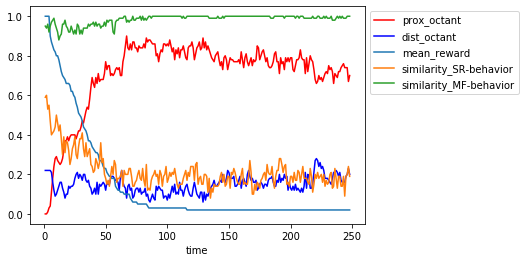

In [355]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt
df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-45", df3["angle"]=="45"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
df2 = df2.groupby("time").mean()
df2["isinoctant_proximal"][1:249].plot(color="r")
df2["isinoctant_distal"][1:249].plot(color="b")
df2["rew_func_sum"][1:249].plot()
df2["Qcombsr"][1:249].plot()
df2["Qcombmf"][1:249].plot()
plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

In [18]:
from scipy.stats import pearsonr

def get_pearson(angle, df):

    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-angle), df3["angle"]==str(angle)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
    df2 = df2.groupby("time").mean()

    print(pearsonr(df2['isinoctant_distal'][1:249], df2["rew_func_sum"][1:249]))

get_pearson(0, df)
get_pearson(45, df)
get_pearson(90, df)
get_pearson(135, df)
get_pearson(180, df)

(-0.8155099460389912, 2.3186219571695825e-60)
(0.08180760206447944, 0.19915876916704)
(0.6836226218871605, 1.6696003934946906e-35)
(0.6337693580994878, 2.922915152658276e-29)
(0.5480178008118362, 7.684455679970095e-21)


In [17]:
from scipy.stats import pearsonr

def get_pearson(angle, df):

    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-angle), df3["angle"]==str(angle)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
    df2 = df2.groupby("time").mean()

    print(pearsonr(df2['isinoctant_proximal'][1:249], df2["rew_func_sum"][1:249]))

get_pearson(0, df)
get_pearson(45, df)
get_pearson(90, df)
get_pearson(135, df)
get_pearson(180, df)

(-0.8155099460389912, 2.3186219571695825e-60)
(-0.9468908454824524, 3.268747446883715e-123)
(-0.7457715770339429, 2.7482487849975343e-45)
(-0.6565466489389358, 5.75797228808561e-32)
(-0.7774900713914386, 1.8384719279097896e-51)


In [19]:
df2

index  Unnamed: 0   state     P(SR)  previous_platform  platform  \
time                                                                       
0     7954.06     7954.06  248.93  0.437006               90.0       NaN   
1     7955.06     7955.06  226.08  0.435363               90.0       NaN   
2     7956.06     7956.06  198.57  0.434218               90.0       NaN   
3     7957.06     7957.06  175.78  0.433411               90.0       NaN   
4     7958.06     7958.06  161.48  0.432838               90.0       NaN   
...       ...         ...     ...       ...                ...       ...   
246   8200.06     8200.06   88.80  0.431296               90.0       NaN   
247   8201.06     8201.06   87.02  0.431296               90.0       NaN   
248   8202.06     8202.06   86.71  0.431296               90.0       NaN   
249   8203.06     8203.06   84.27  0.431296               90.0       NaN   
250   8204.06     8204.06   81.19  0.431296               90.0       NaN   

      rew_func_sum     Q_max   Qsr_max  Qcombmf  ...    Qcomb5  syn_prox_mean  \
time                                             ...                            
0             1.00  0.000000  0.000000     0.00  ...  0.000000       0.026056   
1             1.00  0.348214  0.034178     0.98  ...  0.172249       0.026056   
2             1.00  0.394025  0.045373     0.94  ...  0.182680       0.026034   
3             1.00  0.422639  0.076430     0.92  ...  0.195888       0.026039   
4             1.00  0.424741  0.137514     0.91  ...  0.206102       0.026039   
...            ...       ...       ...      ...  ...       ...            ...   
246           0.33  0.416488  0.000521     1.00  ...  0.201014       0.025242   
247           0.33  0.420853  0.001788     0.98  ...  0.205509       0.025236   
248           0.33  0.412928  0.003062     1.00  ...  0.205741       0.025231   
249           0.33  0.411566  0.001798     0.96  ...  0.203169       0.025226   
250           0.33  0.418019  0.002598     0.98  ...  0.204916       0.025225   

      syn_dist_mean  trial  escape time  total trial  total time  agent  \
time                                                                      
0          0.029176    8.0        250.0        91.62     7954.06   49.5   
1          0.029176    8.0        250.0        91.62     7955.06   49.5   
2          0.029141    8.0        250.0        91.62     7956.06   49.5   
3          0.029146    8.0        250.0        91.62     7957.06   49.5   
4          0.029146    8.0        250.0        91.62     7958.06   49.5   
...             ...    ...          ...          ...         ...    ...   
246        0.028401    8.0        250.0        91.62     8200.06   49.5   
247        0.028395    8.0        250.0        91.62     8201.06   49.5   
248        0.028389    8.0        250.0        91.62     8202.06   49.5   
249        0.028384    8.0        250.0        91.62     8203.06   49.5   
250        0.028384    8.0        250.0        91.62     8204.06   49.5   

      isinoctant_distal  isinoctant_proximal  
time                                          
0                  0.21                 0.27  
1                  0.21                 0.27  
2                  0.21                 0.27  
3                  0.21                 0.27  
4                  0.20                 0.27  
...                 ...                  ...  
246                0.11                 0.45  
247                0.10                 0.43  
248                0.10                 0.43  
249                0.11                 0.43  
250                0.09                 0.40  

[251 rows x 38 columns]

In [24]:
df2["previous_coord"]

time
1      248.93
2      226.08
3      198.57
4      175.78
5      161.48
        ...  
246     87.57
247     88.80
248     87.02
249     86.71
250     84.27
Name: previous_coord, Length: 250, dtype: float64

In [29]:
df2

index  Unnamed: 0   state     P(SR)  previous_platform  platform  \
time                                                                       
1     7955.06     7955.06  226.08  0.435363               90.0       NaN   
2     7956.06     7956.06  198.57  0.434218               90.0       NaN   
3     7957.06     7957.06  175.78  0.433411               90.0       NaN   
4     7958.06     7958.06  161.48  0.432838               90.0       NaN   
5     7959.06     7959.06  143.00  0.432426               90.0       NaN   
...       ...         ...     ...       ...                ...       ...   
246   8200.06     8200.06   88.80  0.431296               90.0       NaN   
247   8201.06     8201.06   87.02  0.431296               90.0       NaN   
248   8202.06     8202.06   86.71  0.431296               90.0       NaN   
249   8203.06     8203.06   84.27  0.431296               90.0       NaN   
250   8204.06     8204.06   81.19  0.431296               90.0       NaN   

      rew_func_sum     Q_max   Qsr_max  Qcombmf  ...  syn_prox_mean  \
time                                             ...                  
1             1.00  0.348214  0.034178     0.98  ...       0.026056   
2             1.00  0.394025  0.045373     0.94  ...       0.026034   
3             1.00  0.422639  0.076430     0.92  ...       0.026039   
4             1.00  0.424741  0.137514     0.91  ...       0.026039   
5             0.94  0.428636  0.088758     0.95  ...       0.026036   
...            ...       ...       ...      ...  ...            ...   
246           0.33  0.416488  0.000521     1.00  ...       0.025242   
247           0.33  0.420853  0.001788     0.98  ...       0.025236   
248           0.33  0.412928  0.003062     1.00  ...       0.025231   
249           0.33  0.411566  0.001798     0.96  ...       0.025226   
250           0.33  0.418019  0.002598     0.98  ...       0.025225   

      syn_dist_mean  trial  escape time  total trial  total time  agent  \
time                                                                      
1          0.029176    8.0        250.0        91.62     7955.06   49.5   
2          0.029141    8.0        250.0        91.62     7956.06   49.5   
3          0.029146    8.0        250.0        91.62     7957.06   49.5   
4          0.029146    8.0        250.0        91.62     7958.06   49.5   
5          0.029141    8.0        250.0        91.62     7959.06   49.5   
...             ...    ...          ...          ...         ...    ...   
246        0.028401    8.0        250.0        91.62     8200.06   49.5   
247        0.028395    8.0        250.0        91.62     8201.06   49.5   
248        0.028389    8.0        250.0        91.62     8202.06   49.5   
249        0.028384    8.0        250.0        91.62     8203.06   49.5   
250        0.028384    8.0        250.0        91.62     8204.06   49.5   

      isinoctant_distal  isinoctant_proximal  previous_coord  
time                                                          
1                  0.21                 0.27          226.08  
2                  0.21                 0.27          198.57  
3                  0.21                 0.27          175.78  
4                  0.20                 0.27          161.48  
5                  0.20                 0.27          143.00  
...                 ...                  ...             ...  
246                0.11                 0.45           88.80  
247                0.10                 0.43           87.02  
248                0.10                 0.43           86.71  
249                0.11                 0.43           84.27  
250                0.09                 0.40           81.19  

[250 rows x 39 columns]

In [58]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-180", df3["angle"]=="180"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)
# df2 = df2.groupby("state").mean()
# df2["isinoctant_proximal"][1:249].plot(color="r")
# df2["isinoctant_distal"][1:249].plot(color="b")
# df2["rew_func_sum"][1:249].plot()
# df2["Qcombsr"][1:249].plot()
# df2["Qcombmf"][1:249].plot()
# plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

In [28]:
df2

index  Unnamed: 0   state     P(SR)  previous_platform  platform  \
time                                                                      
0     7938.0      7938.0  249.57  0.460561               90.0       NaN   
1     7939.0      7939.0  219.00  0.000000               90.0       NaN   
2     7940.0      7940.0  188.46  0.000000               90.0       NaN   
3     7941.0      7941.0  167.27  0.000000               90.0       NaN   
4     7942.0      7942.0  147.63  0.000000               90.0       NaN   
...      ...         ...     ...       ...                ...       ...   
246   8184.0      8184.0   83.38  0.000000               90.0       NaN   
247   8185.0      8185.0   81.45  0.000000               90.0       NaN   
248   8186.0      8186.0   83.49  0.000000               90.0       NaN   
249   8187.0      8187.0   84.86  0.000000               90.0       NaN   
250   8188.0      8188.0   88.52  0.000000               90.0       NaN   

      rew_func_sum     Q_max  Qsr_max  Qcombmf  ...    Qcomb5  syn_prox_mean  \
time                                            ...                            
0              1.0  0.000000      0.0      0.0  ...  0.000000       0.025145   
1              1.0  0.326377      0.0      1.0  ...  0.270226       0.025145   
2              1.0  0.382937      0.0      1.0  ...  0.296371       0.025119   
3              1.0  0.420092      0.0      1.0  ...  0.322239       0.025125   
4              1.0  0.434974      0.0      1.0  ...  0.334769       0.025121   
...            ...       ...      ...      ...  ...       ...            ...   
246            1.0  0.369576      0.0      1.0  ...  0.318230       0.023420   
247            1.0  0.376487      0.0      1.0  ...  0.321731       0.023418   
248            1.0  0.375350      0.0      1.0  ...  0.324050       0.023411   
249            1.0  0.372260      0.0      1.0  ...  0.320930       0.023404   
250            1.0  0.367563      0.0      1.0  ...  0.316019       0.023395   

      syn_dist_mean  trial  escape time  total trial  total time  agent  \
time                                                                      
0          0.028259    8.0        250.0        89.46      7938.0   49.5   
1          0.028259    8.0        250.0        89.46      7939.0   49.5   
2          0.028218    8.0        250.0        89.46      7940.0   49.5   
3          0.028223    8.0        250.0        89.46      7941.0   49.5   
4          0.028219    8.0        250.0        89.46      7942.0   49.5   
...             ...    ...          ...          ...         ...    ...   
246        0.026411    8.0        250.0        89.46      8184.0   49.5   
247        0.026409    8.0        250.0        89.46      8185.0   49.5   
248        0.026401    8.0        250.0        89.46      8186.0   49.5   
249        0.026393    8.0        250.0        89.46      8187.0   49.5   
250        0.026384    8.0        250.0        89.46      8188.0   49.5   

      isinoctant_distal  isinoctant_proximal  
time                                          
0                  0.29                 0.26  
1                  0.29                 0.26  
2                  0.29                 0.26  
3                  0.29                 0.26  
4                  0.28                 0.26  
...                 ...                  ...  
246                0.16                 0.52  
247                0.17                 0.54  
248                0.20                 0.53  
249                0.15                 0.49  
250                0.17                 0.49  

[251 rows x 38 columns]

In [68]:
print(df2.loc[11991, "state"])

25


In [43]:
df2.loc[df2.index[np.logical_and(df2["time"]==240, df2["agent"]==11)],"state"]

119917    2
Name: state, dtype: int64

In [14]:
for i in range(100):
    for t in range(1,250):
        ilo1 = df2[df2[np.logical_and(df2["time"]==t-1, df2["agent"]==i)]].iloc[0].index
        ilo2 = df2[df2[np.logical_and(df2["time"]==t, df2["agent"]==i)]].iloc[0].index
        df2.loc[ilo2].previous_coord = df2.loc[ilo2].state

NameError: name 'df2' is not defined

In [17]:
df2[df2[np.logical_and(df2["time"]==120, df2["agent"]==12)]].iloc[0].index

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

In [54]:
df2

level_0  index  Unnamed: 0  state     P(SR)  previous_platform  \
time agent                                                                   
0    0         7032   7032        7032    230  0.495147               90.0   
     1        18950   8492        8492    257  0.408512               90.0   
     2        27252   7103        7103    230  0.379877               90.0   
     3        37735   8386        8386    243  0.420604               90.0   
     4        46600   8614        8614    243  0.412939               90.0   
...             ...    ...         ...    ...       ...                ...   
250  95      979569  10885       10885     40  0.433025               90.0   
     96      985425   5855        5855     44  0.397106               90.0   
     97      996042   7160        7160     48  0.485310               90.0   
     98     1006131   7100        7100      3  0.453486               90.0   
     99     1017958   9095        9095     65  0.337434               90.0   

            platform  rew_func_sum     Q_max       Qsr_max  ...    Qcomb5  \
time agent                                                  ...             
0    0           NaN           1.0  0.000000  0.000000e+00  ...  0.000000   
     1           NaN           1.0  0.000000  0.000000e+00  ...  0.000000   
     2           NaN           1.0  0.000000  0.000000e+00  ...  0.000000   
     3           NaN           1.0  0.000000  0.000000e+00  ...  0.000000   
     4           NaN           1.0  0.000000  0.000000e+00  ...  0.000000   
...              ...           ...       ...           ...  ...       ...   
250  95          NaN           0.0  0.377077  0.000000e+00  ...  0.200230   
     96          NaN           1.0  0.475081  7.575138e-08  ...  0.258252   
     97          NaN           0.0  0.384890  0.000000e+00  ...  0.198099   
     98          NaN           0.0  0.420402  0.000000e+00  ...  0.208638   
     99          NaN           0.0  0.353628  0.000000e+00  ...  0.222276   

            syn_prox_mean  syn_dist_mean  trial  escape time  total trial  \
time agent                                                                  
0    0           0.027063       0.029149      8          250           72   
     1           0.024220       0.028083      8          250          108   
     2           0.025483       0.027987      8          250           90   
     3           0.023556       0.027111      8          250          126   
     4           0.023846       0.027884      8          250          126   
...                   ...            ...    ...          ...          ...   
250  95          0.023996       0.027474      8          250          126   
     96          0.026858       0.029956      8          250           72   
     97          0.025822       0.030205      8          250           72   
     98          0.023911       0.026771      8          250           72   
     99          0.022030       0.027203      8          250          126   

            total time  isinoctant_distal  isinoctant_proximal  previous_coord  
time agent                                                                      
0    0            7032                  0                    0             230  
     1            8492                  0                    0             257  
     2            7103                  0                    0             230  
     3            8386                  0                    1             243  
     4            8614                  0                    1             243  
...                ...                ...                  ...             ...  
250  95          10885                  0                    0              40  
     96           5855                  0                    0              44  
     97           7160                  0                    1              48  
     98           7100                  0                    1               3  
     99           909

In [86]:
print(df2.loc[11991, "state"])
print(df2.loc[df2.index[np.logical_and(df2["time"]==200, df2["agent"]==90)],"state"])

25
20090    63
Name: state, dtype: int64


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


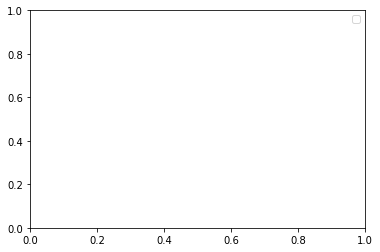

In [96]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-180", df3["angle"]=="180"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

df2 = df2.reset_index()
df2 = df2.groupby(["time", "agent"]).mean()
df2 = df2.reset_index()

plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

def is_explo(previous_coord, coord, platform_coord):
    return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])

df2["previous_coord"] = df2["state"]
for i in range(100):
    print(i)
    for t in range(1,250):
        ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
        ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
        df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]
        

#df2=df2[2:len(df2)]
df2["exploration"] = df2.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
df2["exploration2"] = df2.apply(lambda row: row.exploration and bool(row.Qcombsr), axis=1)



In [30]:
df.distal_posx

0        pretraining
1        pretraining
2        pretraining
3        pretraining
4        pretraining
            ...     
10778              0
10779              0
10780              0
10781              0
10782              0
Name: distal_posx, Length: 1029148, dtype: object

In [33]:
df2.distal_posx

AttributeError: 'DataFrame' object has no attribute 'distal_posx'

In [37]:
df.proximal_posx

0             pretraining
1             pretraining
2             pretraining
3             pretraining
4             pretraining
               ...       
10778    4.08248290463863
10779    4.08248290463863
10780    4.08248290463863
10781    4.08248290463863
10782    4.08248290463863
Name: proximal_posx, Length: 1029148, dtype: object

In [44]:
df.proximal_posx.iloc[0]

'pretraining'

In [52]:
int(7.3)

7

In [55]:
len(df2)

25100

angle: i
has_reached_prox
0    0.059363
1    0.843506
2    0.097131
Name: time, dtype: float64

angle: i
has_reached_prox
0    0.070956
1    0.815418
2    0.113625
Name: time, dtype: float64

angle: i
has_reached_prox
0    0.103506
1    0.644183
2    0.252311
Name: time, dtype: float64

angle: i
has_reached_prox
0    0.227729
1    0.610120
2    0.162151
Name: time, dtype: float64

angle: i
has_reached_prox
0    0.277131
1    0.545219
2    0.177649
Name: time, dtype: float64



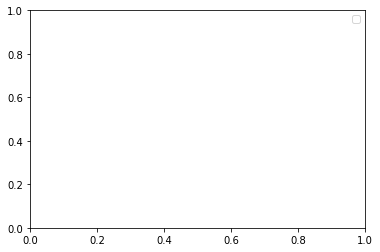

In [57]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt


for i in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-i), df3["angle"]==str(i)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])

    df2["has_reached_prox"] = 0
    for i in range(100):
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
#             if  df2.loc[ilo1, "has_reached_prox"] == 2:
#                 df2.loc[ilo2, "has_reached_prox"] = 2

    print("angle: i")
    df3=df2.groupby(["has_reached_prox"]).count()
    print(df3["time"]/25100)
    print()

#df2=df2[2:len(df2)]
#df2["exploration"] = df2.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df2["exploration2"] = df2.apply(lambda row: row.exploration and bool(row.Qcombsr), axis=1)



angle: i
has_reached_prox
0    0.059363
1    0.197211
2    0.743426
Name: time, dtype: float64

angle: i
has_reached_prox
0    0.070956
1    0.241753
2    0.687291
Name: time, dtype: float64

angle: i
has_reached_prox
0    0.103506
1    0.213147
2    0.683347
Name: time, dtype: float64

angle: i
has_reached_prox
0    0.227729
1    0.154701
2    0.617570
Name: time, dtype: float64

angle: i
has_reached_prox
0    0.277131
1    0.105578
2    0.617291
Name: time, dtype: float64



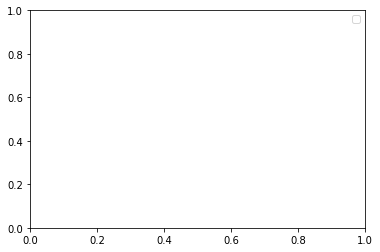

In [56]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt


for i in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-i), df3["angle"]==str(i)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])

    df2["has_reached_prox"] = 0
    for i in range(100):
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1:
                df2.loc[ilo2, "has_reached_prox"] = 2
            if  df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2

    print("angle: i")
    df3=df2.groupby(["has_reached_prox"]).count()
    print(df3["time"]/25100)
    print()

#df2=df2[2:len(df2)]
#df2["exploration"] = df2.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df2["exploration2"] = df2.apply(lambda row: row.exploration and bool(row.Qcombsr), axis=1)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


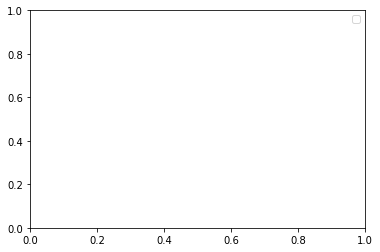

In [50]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

df3 = df.reset_index()
df2 = df3[np.logical_and(np.logical_or(df3["angle"]=="-45", df3["angle"]=="45"), df3["agent"]>=0)]
#df2["time"] = pd.cut(df2['time'], 10)
df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

df2 = df2.reset_index()
proximal_posx=df2.proximal_posx.iloc[0]
proximal_posy=df2.proximal_posy.iloc[0]
df2 = df2.groupby(["time", "agent"]).mean()
df2 = df2.reset_index()
df2["proximal_posx"] = float(proximal_posx)
df2["proximal_posy"] = float(proximal_posy)

plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

def is_explo(previous_coord, coord, platform_coord):
    return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])

df2["has_reached_prox"] = 0
for i in range(100):
    print(i)
    for t in range(1,250):
        ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
        ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
        
        if isinoctant(coords[df2.loc[ilo2, "state"]], [int(df2.loc[ilo2, "proximal_posx"]), int(df2.loc[ilo2, "proximal_posy"])]):
            df2.loc[ilo2, "has_reached_prox"] = 1
        elif df2.loc[ilo1, "has_reached_prox"] == 1:
            df2.loc[ilo2, "has_reached_prox"] = 2
        if  df2.loc[ilo1, "has_reached_prox"] == 2:
            df2.loc[ilo2, "has_reached_prox"] = 2
        
        

#df2=df2[2:len(df2)]
#df2["exploration"] = df2.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df2["exploration2"] = df2.apply(lambda row: row.exploration and bool(row.Qcombsr), axis=1)



In [54]:
df3=df2.groupby(["has_reached_prox"]).count()
df3

time  agent  level_0  index  Unnamed: 0  state  P(SR)  \
has_reached_prox                                                           
0                  8729   8729     8729   8729        8729   8729   8729   
1                  3652   3652     3652   3652        3652   3652   3652   
2                 12719  12719    12719  12719       12719  12719  12719   

                  previous_platform  platform  rew_func_sum  ...  \
has_reached_prox                                             ...   
0                              8729         0          8729  ...   
1                              3652         0          3652  ...   
2                             12719         0         12719  ...   

                  syn_prox_mean  syn_dist_mean  trial  escape time  \
has_reached_prox                                                     
0                          8729           8729   8729         8729   
1                          3652           3652   3652         3652   
2                         12719          12719  12719        12719   

                  total trial  total time  isinoctant_distal  \
has_reached_prox                                               
0                        8729        8729               8729   
1                        3652        3652               3652   
2                       12719       12719              12719   

                  isinoctant_proximal  proximal_posx  proximal_posy  
has_reached_prox                                                     
0                                8729           8729           8729  
1                                3652           3652           3652  
2                               12719          12719          12719  

[3 rows x 42 columns]

In [52]:
#df3 = df2.groupby(["has_reached_prox", "agent"]).sum()
df3=df2.groupby(["has_reached_prox", "agent"]).count()
df3.groupby(["has_reached_prox"]).mean()


time     level_0       index  Unnamed: 0       state  \
has_reached_prox                                                               
0                  87.290000   87.290000   87.290000   87.290000   87.290000   
1                  48.693333   48.693333   48.693333   48.693333   48.693333   
2                 176.652778  176.652778  176.652778  176.652778  176.652778   

                       P(SR)  previous_platform  platform  rew_func_sum  \
has_reached_prox                                                          
0                  87.290000          87.290000       0.0     87.290000   
1                  48.693333          48.693333       0.0     48.693333   
2                 176.652778         176.652778       0.0    176.652778   

                       Q_max  ...  syn_prox_mean  syn_dist_mean       trial  \
has_reached_prox              ...                                             
0                  87.290000  ...      87.290000      87.290000   87.290000   
1                  48.693333  ...      48.693333      48.693333   48.693333   
2                 176.652778  ...     176.652778     176.652778  176.652778   

                  escape time  total trial  total time  isinoctant_distal  \
has_reached_prox                                                            
0                   87.290000    87.290000   87.290000          87.290000   
1                   48.693333    48.693333   48.693333          48.693333   
2                  176.652778   176.652778  176.652778         176.652778   

                  isinoctant_proximal  proximal_posx  proximal_posy  
has_reached_prox                                                     
0                           87.290000      87.290000      87.290000  
1                           48.693333      48.693333      48.693333  
2                          176.652778     176.652778     176.652778  

[3 rows x 41 columns]

In [34]:
df2.groupby(["has_reached_prox"]).mean()


time      agent        level_0        index  \
has_reached_prox                                                      
0                  26.583221  50.681208  530631.881208  7811.993289   
1                  65.742020  47.855960  501433.073939  7366.570909   
2                 148.578135  49.841801  522674.104180  8255.492497   

                   Unnamed: 0       state   P(SR)  previous_platform  \
has_reached_prox                                                       
0                 7811.993289  130.238926  0.0295               90.0   
1                 7366.570909   97.588283  0.0000               90.0   
2                 8255.492497  100.843462  0.0000               90.0   

                  platform  rew_func_sum  ...  syn_prox_mean  syn_dist_mean  \
has_reached_prox                          ...                                 
0                      NaN           1.0  ...       0.025252       0.028452   
1                      NaN           1.0  ...       0.025361       0.028191   
2                      NaN           1.0  ...       0.023919       0.026878   

                  trial  escape time  total trial   total time  \
has_reached_prox                                                 
0                   8.0        250.0    90.120805  7811.993289   
1                   8.0        250.0    81.625455  7366.570909   
2                   8.0        250.0    93.180386  8255.492497   

                  isinoctant_distal  isinoctant_proximal  proximal_posx  \
has_reached_prox                                                          
0                          0.064430             0.064430            0.0   
1                          1.000000             1.000000            0.0   
2                          0.869346             0.869346            0.0   

                  proximal_posy  
has_reached_prox                 
0                     -5.773503  
1                     -5.773503  
2                     -5.773503  

[3 rows x 42 columns]

In [26]:
df2.groupby(["has_reached_prox"]).mean()


time      agent        level_0        index  \
has_reached_prox                                                      
0                 113.090616  47.668012  500292.701816  8371.680928   
1                  88.889572  50.010838  523035.526362  6750.004979   
2                 145.491084  50.893597  533646.227242  8328.120075   

                   Unnamed: 0       state     P(SR)  previous_platform  \
has_reached_prox                                                         
0                 8371.680928  113.940565  0.004666               90.0   
1                 6750.004979   86.224956  0.000000               90.0   
2                 8328.120075   91.393427  0.000000               90.0   

                  platform  rew_func_sum  ...  syn_prox_mean  syn_dist_mean  \
has_reached_prox                          ...                                 
0                      NaN           1.0  ...       0.023963       0.026900   
1                      NaN           1.0  ...       0.025192       0.027699   
2                      NaN           1.0  ...       0.023417       0.026226   

                  trial  escape time  total trial   total time  \
has_reached_prox                                                 
0                   8.0        250.0    94.388295  8371.680928   
1                   8.0        250.0    71.372583  6750.004979   
2                   8.0        250.0    92.091033  8328.120075   

                  isinoctant_distal  isinoctant_proximal  proximal_posx  \
has_reached_prox                                                          
0                          0.157417             0.544400       5.773503   
1                          0.000000             0.966901       5.773503   
2                          0.089334             0.640200       5.773503   

                  proximal_posy  
has_reached_prox                 
0                 -3.535251e-16  
1                 -3.535251e-16  
2                 -3.535251e-16  

[3 rows x 42 columns]

In [24]:
df2.groupby(["has_reached_prox"]).mean()


time      agent        level_0        index  \
has_reached_prox                                                      
0                  84.471392  47.454572  498358.105377  8610.926682   
1                  76.443396  49.398113  516919.603019  6926.129434   
2                 151.500065  50.435717  528568.961404  8011.452885   

                   Unnamed: 0       state     P(SR)  previous_platform  \
has_reached_prox                                                         
0                 8610.926682  111.401380  0.006621               90.0   
1                 6926.129434   81.026038  0.000000               90.0   
2                 8011.452885   76.467923  0.000000               90.0   

                  platform  rew_func_sum  ...  syn_prox_mean  syn_dist_mean  \
has_reached_prox                          ...                                 
0                      NaN           1.0  ...       0.024033       0.027455   
1                      NaN           1.0  ...       0.025145       0.027866   
2                      NaN           1.0  ...       0.024186       0.027110   

                  trial  escape time  total trial   total time  \
has_reached_prox                                                 
0                   8.0        250.0    98.327200  8610.926682   
1                   8.0        250.0    76.904151  6926.129434   
2                   8.0        250.0    87.626565  8011.452885   

                  isinoctant_distal  isinoctant_proximal  proximal_posx  \
has_reached_prox                                                          
0                          0.405837             0.010782   7.070502e-16   
1                          0.000000             1.000000   7.070502e-16   
2                          0.065509             0.712211   7.070502e-16   

                  proximal_posy  
has_reached_prox                 
0                      5.773503  
1                      5.773503  
2                      5.773503  

[3 rows x 42 columns]

In [32]:
df2[df2["agent"]==15]

time  agent  level_0  index  Unnamed: 0  state     P(SR)  \
15        0     15   161925   6878        6878    243  0.444168   
115       1     15   161926   6879        6879    243  0.000000   
215       2     15   161927   6880        6880    243  0.000000   
315       3     15   161928   6881        6881    192  0.000000   
415       4     15   161929   6882        6882    193  0.000000   
...     ...    ...      ...    ...         ...    ...       ...   
24615   246     15   162171   7124        7124    162  0.000000   
24715   247     15   162172   7125        7125    210  0.000000   
24815   248     15   162173   7126        7126    211  0.000000   
24915   249     15   162174   7127        7127    210  0.000000   
25015   250     15   162175   7128        7128    211  0.000000   

       previous_platform  platform  rew_func_sum  ...  syn_dist_mean  trial  \
15                  90.0       NaN           1.0  ...       0.028872      8   
115                 90.0       NaN           1.0  ...       0.028872      8   
215                 90.0       NaN           1.0  ...       0.028792      8   
315                 90.0       NaN           1.0  ...       0.028804      8   
415                 90.0       NaN           1.0  ...       0.028808      8   
...                  ...       ...           ...  ...            ...    ...   
24615               90.0       NaN           1.0  ...       0.026670      8   
24715               90.0       NaN           1.0  ...       0.026675      8   
24815               90.0       NaN           1.0  ...       0.026662      8   
24915               90.0       NaN           1.0  ...       0.026644      8   
25015               90.0       NaN           1.0  ...       0.026621      8   

       escape time  total trial  total time  isinoctant_distal  \
15             250           90        6878                  0   
115            250           90        6879                  0   
215            250           90        6880                  0   
315            250           90        6881                  0   
415            250           90        6882                  0   
...            ...          ...         ...                ...   
24615          250           90        7124                  0   
24715          250           90        7125                  0   
24815          250           90        7126                  0   
24915          250           90        7127                  0   
25015          250           90        7128                  0   

       isinoctant_proximal  proximal_posx  proximal_posy  has_reached_prox  
15                       0       5.773503  -3.535251e-16                 0  
115                      0       5.773503  -3.535251e-16                 0  
215                      0       5.773503  -3.535251e-16                 0  
315                      0       5.773503  -3.535251e-16                 0  
415                      0       5.773503  -3.535251e-16                 0  
...                    ...            ...            ...               ...  
24615                    0       5.773503  -3.535251e-16                 0  
24715                    0       5.773503  -3.535251e-16                 0  
24815                    0       5.773503  -3.535251e-16                 0  
24915                    0       5.773503  -3.535251e-16                 0  
25015                    0       5.773503  -3.535251e-16                 0  

[251 rows x 43 columns]

In [120]:
df2["exploration2"] = df2.apply(lambda row: row.exploration and bool(row.Qcombsr), axis=1)
df2["exploration3"] = df2.apply(lambda row: row.exploration and not bool(row.Qcombsr), axis=1)

In [101]:
df4

agent    level_0    index  Unnamed: 0   state     P(SR)  \
time                                                            
0      49.5  512561.28  7954.06     7954.06  248.93  0.437006   
1      49.5  512562.28  7955.06     7955.06  226.08  0.435363   
2      49.5  512563.28  7956.06     7956.06  198.57  0.434218   
3      49.5  512564.28  7957.06     7957.06  175.78  0.433411   
4      49.5  512565.28  7958.06     7958.06  161.48  0.432838   
...     ...        ...      ...         ...     ...       ...   
246    49.5  512807.28  8200.06     8200.06   88.80  0.431296   
247    49.5  512808.28  8201.06     8201.06   87.02  0.431296   
248    49.5  512809.28  8202.06     8202.06   86.71  0.431296   
249    49.5  512810.28  8203.06     8203.06   84.27  0.431296   
250    49.5  512811.28  8204.06     8204.06   81.19  0.431296   

      previous_platform  platform  rew_func_sum     Q_max  ...  syn_prox_mean  \
time                                                       ...                  
0                  90.0       NaN          1.00  0.000000  ...       0.026056   
1                  90.0       NaN          1.00  0.348214  ...       0.026056   
2                  90.0       NaN          1.00  0.394025  ...       0.026034   
3                  90.0       NaN          1.00  0.422639  ...       0.026039   
4                  90.0       NaN          1.00  0.424741  ...       0.026039   
...                 ...       ...           ...       ...  ...            ...   
246                90.0       NaN          0.33  0.416488  ...       0.025242   
247                90.0       NaN          0.33  0.420853  ...       0.025236   
248                90.0       NaN          0.33  0.412928  ...       0.025231   
249                90.0       NaN          0.33  0.411566  ...       0.025226   
250                90.0       NaN          0.33  0.418019  ...       0.025225   

      syn_dist_mean  trial  escape time  total trial  total time  \
time                                                               
0          0.029176    8.0        250.0        91.62     7954.06   
1          0.029176    8.0        250.0        91.62     7955.06   
2          0.029141    8.0        250.0        91.62     7956.06   
3          0.029146    8.0        250.0        91.62     7957.06   
4          0.029146    8.0        250.0        91.62     7958.06   
...             ...    ...          ...          ...         ...   
246        0.028401    8.0        250.0        91.62     8200.06   
247        0.028395    8.0        250.0        91.62     8201.06   
248        0.028389    8.0        250.0        91.62     8202.06   
249        0.028384    8.0        250.0        91.62     8203.06   
250        0.028384    8.0        250.0        91.62     8204.06   

      isinoctant_distal  isinoctant_proximal  previous_coord  exploration  
time                                                                       
0                  0.21                 0.27          248.93         0.00  
1                  0.21                 0.27          248.93         0.02  
2                  0.21                 0.27          226.08         0.11  
3                  0.21                 0.27          198.57         0.23  
4                  0.20                 0.27          175.78         0.27  
...                 ...                  ...             ...          ...  
246                0.11                 0.45           87.57         0.49  
247                0.10                 0.43           88.80         0.42  
248                0.10                 0.43           87.02         0.52  
249                0.11                 0.43           86.71         0.41  
250                0.09                 0.40           81.19         0.00  

[251 rows x 41 columns]

In [137]:
df4 = df2.groupby("time").mean()


In [67]:
df7 = df3.groupby("state").mean()

In [69]:
df3=df2

In [59]:
from scipy.stats import entropy
df2["entro_sr"] = df2.apply(lambda row: entropy(np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5])), axis=1)
df2["entro_mf"] = df2.apply(lambda row: entropy(np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5])), axis=1)
df2["var_sr"] = df2.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df2["var_mf"] = df2.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)
df7 = df2.groupby("state").mean()

In [60]:
from scipy.stats import entropy
df2["entro_sr"] = df2.apply(lambda row: entropy(np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5])), axis=1)
df2["entro_mf"] = df2.apply(lambda row: entropy(np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5])), axis=1)

In [135]:
df2

time  agent  level_0  index  Unnamed: 0  state     P(SR)  \
0         0      0     7032   7032        7032    230  0.495147   
1         0      1    18950   8492        8492    257  0.408512   
2         0      2    27252   7103        7103    230  0.379877   
3         0      3    37735   8386        8386    243  0.420604   
4         0      4    46600   8614        8614    243  0.412939   
...     ...    ...      ...    ...         ...    ...       ...   
25095   250     95   979569  10885       10885     40  0.433025   
25096   250     96   985425   5855        5855     44  0.397106   
25097   250     97   996042   7160        7160     48  0.485310   
25098   250     98  1006131   7100        7100      3  0.453486   
25099   250     99  1017958   9095        9095     65  0.337434   

       previous_platform  platform  rew_func_sum  ...  escape time  \
0                   90.0       NaN           1.0  ...          250   
1                   90.0       NaN           1.0  ...          250   
2                   90.0       NaN           1.0  ...          250   
3                   90.0       NaN           1.0  ...          250   
4                   90.0       NaN           1.0  ...          250   
...                  ...       ...           ...  ...          ...   
25095               90.0       NaN           0.0  ...          250   
25096               90.0       NaN           1.0  ...          250   
25097               90.0       NaN           0.0  ...          250   
25098               90.0       NaN           0.0  ...          250   
25099               90.0       NaN           0.0  ...          250   

       total trial  total time  isinoctant_distal  isinoctant_proximal  \
0               72        7032                  0                    0   
1              108        8492                  0                    0   
2               90        7103                  0                    0   
3              126        8386                  0                    1   
4              126        8614                  0                    1   
...            ...         ...                ...                  ...   
25095          126       10885                  0                    0   
25096           72        5855                  0                    0   
25097           72        7160                  0                    1   
25098           72        7100                  0                    1   
25099          126        9095                  0                    0   

       previous_coord  exploration  exploration2  exploration3        var_sr  
0                 230        False         False         False  0.000000e+00  
1                 257        False         False         False  0.000000e+00  
2                 230        False         False         False  0.000000e+00  
3                 243        False         False         False  0.000000e+00  
4                 243        False         False         False  0.000000e+00  
...               ...          ...           ...           ...           ...  
25095              40        False         False         False  0.000000e+00  
25096              44        False         False         False  7.651907e-16  
25097              48        False         False         False  0.000000e+00  
25098               3        False         False         False  0.000000e+00  
25099              65        False         False         False  0.000000e+00  

[25100 rows x 45 columns]

In [149]:
df4["var_sr"] = df4["var_sr"]*3

In [141]:
df4["var_mf"] = df4["var_mf"]*10

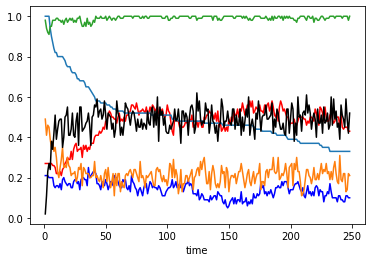

In [152]:
df4["isinoctant_proximal"][1:249].plot(color="r")
df4["isinoctant_distal"][1:249].plot(color="b")
df4["rew_func_sum"][1:249].plot()
df4["Qcombsr"][1:249].plot()
df4["Qcombmf"][1:249].plot()
df4["exploration"][1:249].plot(color="black")

In [320]:
df5 = df2.groupby(["time"]).mean()

In [334]:
#df5.reset_index()
df5 = df2.groupby(["rew_func_sum", "agent", "time"]).mean()
df5 = df5.groupby(["rew_func_sum", "agent"]).mean()
df5 = df5.groupby("rew_func_sum").mean()

In [335]:
df5

level_0        index   Unnamed: 0       state     P(SR)  \
rew_func_sum                                                                  
0.0           510427.380597  8353.873134  8353.873134   92.594145  0.421512   
1.0           512624.240000  8017.020000  8017.020000  120.014424  0.431905   

              previous_platform  platform     Q_max   Qsr_max   Qcombmf  ...  \
rew_func_sum                                                             ...   
0.0                        90.0       NaN  0.420683  0.000000  1.000000  ...   
1.0                        90.0       NaN  0.396497  0.119309  0.873727  ...   

              total trial   total time  isinoctant_distal  \
rew_func_sum                                                
0.0             95.104478  8353.873134           0.290405   
1.0             91.620000  8017.020000           0.236996   

              isinoctant_proximal  previous_coord  exploration  exploration2  \
rew_func_sum                                                                   
0.0                      0.255995       92.631622     0.499389      0.111631   
1.0                      0.358907      127.412510     0.318219      0.071318   

              exploration3    var_sr   var_mf  
rew_func_sum                                   
0.0               0.387758  0.000000  0.00150  
1.0               0.246901  0.010202  0.00212  

[2 rows x 43 columns]

In [331]:
df5=df5.reset_index()
df5[df5["rew_func_sum"]==0.0]["isinoctant_proximal"].mean()

ValueError: cannot insert level_0, already exists

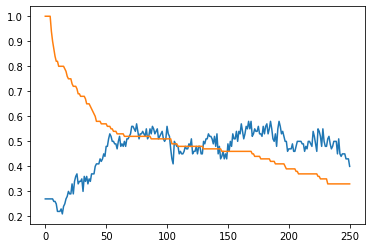

In [315]:
#df5=df5.reset_index()
df5["isinoctant_proximal"].plot()
df5["rew_func_sum"].plot()

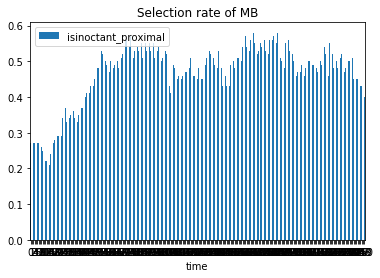

In [298]:
axes = df5[["isinoctant_proximal"]].plot.bar(title="Selection rate of MB", rot=0)

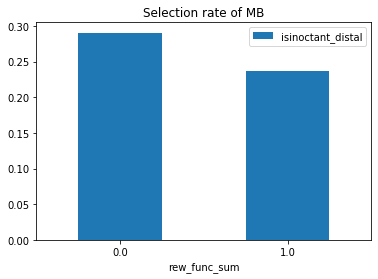

In [336]:
axes = df5[["isinoctant_distal"]].plot.bar(title="Selection rate of MB", rot=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

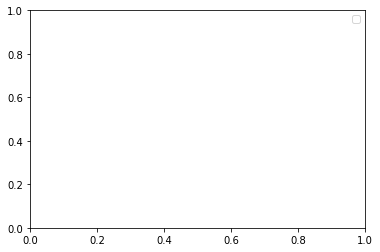

In [8]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

list_of_dataframes = []
for ang in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-ang), df3["angle"]==str(ang)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)
    df2["angle"] = abs(int(ang))

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])


    
    df2["previous_coord"] = df2["state"]
    df2["has_reached_prox"] = 0
    for i in range(100):
        print(i)
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
            df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
    #         if  df2.loc[ilo1, "has_reached_prox"] == 2:
    #             df2.loc[ilo2, "has_reached_prox"] = 2
    list_of_dataframes.append(df2)
df12 = pd.concat(list_of_dataframes)
#     print("angle: i")
#     df3=df2.groupby(["has_reached_prox", "arbitrator_choice"]).count()
#     print(df3["time"]/50200)
#     print()

#df2=df2[2:len(df2)]
#df2["exploration"] = df2.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df2["exploration2"] = df2.apply(lambda row: row.exploration and bool(row.Qcombsr), axis=1)



In [74]:
def is_prox(previous_coord, coord, prox_x, prox_y):
    return calculateDistance(coords[previous_coord], (prox_x, prox_y)) >= calculateDistance(coords[coord], (prox_x, prox_y))

In [75]:
#df12["exploration_MB"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
#df12["distal_MF"] = df12.apply(lambda row: is_explo(row.previous_coord, row.state, row.previous_platform), axis=1)
df12["proximal_MF"] = df12.apply(lambda row: is_prox(row.previous_coord, row.state, row.proximal_posx, row.proximal_posy), axis=1)

In [56]:
def yolo(arbi_choice, explo, proxi_MF):
    if arbi_choice and explo:
        return "MB not platform"
    elif arbi_choice and not explo:
        return "MB toward platform"
    elif not arbi_choice and proxi_MF:
        return "MF toward proximal"
    else:
        return "MF not proximal"
    
df12["Strategies"] = df12.apply(lambda row: yolo(row.arbitrator_choice, row.exploration_MB, row.proximal_MF), axis=1)

In [14]:
df12

time  agent  level_0  index  Unnamed: 0  state     P(SR)  \
0         0      0     6918   6918        6918    230  0.457439   
1         0      1    19964  10695       10695    257  0.308250   
2         0      2    29562   9347        9347    257  0.363568   
3         0      3    39402   9589        9589    230  0.419254   
4         0      4    49481   8779        8779    243  0.388182   
...     ...    ...      ...    ...         ...    ...       ...   
25095   250     95   979987   5073        5073     77  0.000000   
25096   250     96   990246   5997        5997     22  0.000000   
25097   250     97  1003279   9955        9955     75  0.000000   
25098   250     98  1015653   8405        8405     19  0.000000   
25099   250     99  1028265   9900        9900     28  0.000000   

       previous_platform  platform  rew_func_sum  ...  escape time  \
0                   90.0       NaN           1.0  ...          250   
1                   90.0       NaN           1.0  ...          250   
2                   90.0       NaN           1.0  ...          250   
3                   90.0       NaN           1.0  ...          250   
4                   90.0       NaN           1.0  ...          250   
...                  ...       ...           ...  ...          ...   
25095               90.0       NaN           1.0  ...          250   
25096               90.0       NaN           1.0  ...          250   
25097               90.0       NaN           1.0  ...          250   
25098               90.0       NaN           1.0  ...          250   
25099               90.0       NaN           1.0  ...          250   

       total trial  total time  isinoctant_distal  isinoctant_proximal  \
0               90        6918                  0                    0   
1              126       10695                  0                    0   
2              126        9347                  0                    0   
3              108        9589                  0                    0   
4              108        8779                  0                    0   
...            ...         ...                ...                  ...   
25095           54        5073                  0                    0   
25096           72        5997                  0                    0   
25097           54        9955                  0                    1   
25098           72        8405                  1                    0   
25099          108        9900                  0                    1   

       proximal_posx  proximal_posy  angle  previous_coord  has_reached_prox  
0       0.000000e+00      -5.773503      0             230                 0  
1       0.000000e+00      -5.773503      0             257                 0  
2       0.000000e+00      -5.773503      0             257                 0  
3       0.000000e+00      -5.773503      0             230                 0  
4       0.000000e+00      -5.773503      0             243                 0  
...              ...            ...    ...             ...               ...  
25095   7.070502e-16       5.773503    180              77                 0  
25096   7.070502e-16       5.773503    180              22                 0  
25097   7.070502e-16       5.773503    180              75                 0  
25098   7.070502e-16       5.773503    180              19                 0  
25099   7.070502e-16       5.773503    180              28                 0  

[125500 rows x 45 columns]

In [36]:
data2=df12.groupby(["has_reached_prox", "angle"]).count()
data2 = data2["time"]/25100


In [37]:
data3=df12.groupby(["has_reached_prox", "angle"]).count()
data3 = data3["time"]/25100


In [38]:
data4=df12.groupby(["has_reached_prox", "angle"]).count()
data4 = data4["time"]/25100

In [39]:
data2 = data2.reset_index()
data2 = data2[data2["has_reached_prox"]==0]
data2 = data2.set_index(["angle"], drop=True).time

In [40]:
data3 = data3.reset_index()
data3 = data3[data3["has_reached_prox"]==1]
data3 = data3.set_index(["angle"], drop=True).time

In [41]:
data4 = data4.reset_index()
data4 = data4[data4["has_reached_prox"]==2]
data4 = data4.set_index(["angle"], drop=True).time

In [23]:
data2

angle
0      0.029681
45     0.035478
90     0.051753
135    0.113865
180    0.138566
Name: time, dtype: float64

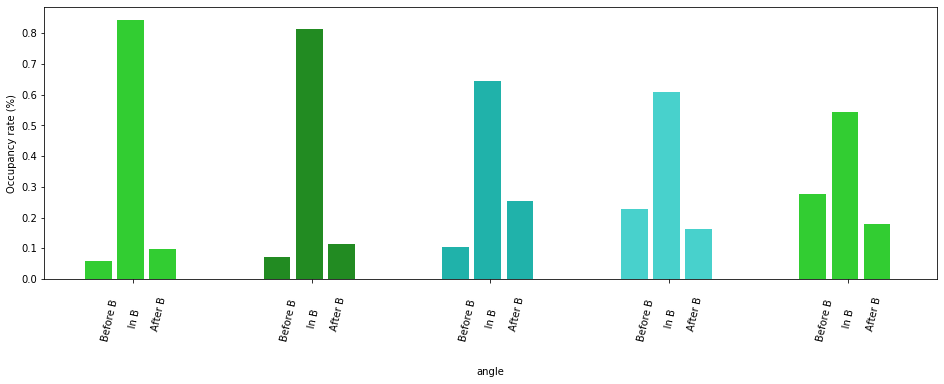

In [42]:
fig, ax = plt.subplots(figsize=(16,5))
#data2["time"].plot(kind='bar', position=1, ax=ax)


data2.plot(kind='bar', position=1.8, ax=ax, legend=False,stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data3.plot(kind='bar', position=0.6, ax=ax, legend=False,stacked=True,width=0.15,color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])
data4.plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15, color=['limegreen', 'forestgreen', "lightseagreen", "mediumturquoise"])

ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=77)
ax.set_ylabel("Occupancy rate (%)")
plt.xlim((-0.5, len(data2)-0.5));

In [72]:
df12

time  agent  level_0  index  Unnamed: 0  state     P(SR)  \
0         0      0     6918   6918        6918    230  0.457439   
1         0      1    19964  10695       10695    257  0.308250   
2         0      2    29562   9347        9347    257  0.363568   
3         0      3    39402   9589        9589    230  0.419254   
4         0      4    49481   8779        8779    243  0.388182   
...     ...    ...      ...    ...         ...    ...       ...   
25095   250     95   979987   5073        5073     77  0.000000   
25096   250     96   990246   5997        5997     22  0.000000   
25097   250     97  1003279   9955        9955     75  0.000000   
25098   250     98  1015653   8405        8405     19  0.000000   
25099   250     99  1028265   9900        9900     28  0.000000   

       previous_platform  platform  rew_func_sum  ...  escape time  \
0                   90.0       NaN           1.0  ...          250   
1                   90.0       NaN           1.0  ...          250   
2                   90.0       NaN           1.0  ...          250   
3                   90.0       NaN           1.0  ...          250   
4                   90.0       NaN           1.0  ...          250   
...                  ...       ...           ...  ...          ...   
25095               90.0       NaN           1.0  ...          250   
25096               90.0       NaN           1.0  ...          250   
25097               90.0       NaN           1.0  ...          250   
25098               90.0       NaN           1.0  ...          250   
25099               90.0       NaN           1.0  ...          250   

       total trial  total time  isinoctant_distal  isinoctant_proximal  \
0               90        6918                  0                    0   
1              126       10695                  0                    0   
2              126        9347                  0                    0   
3              108        9589                  0                    0   
4              108        8779                  0                    0   
...            ...         ...                ...                  ...   
25095           54        5073                  0                    0   
25096           72        5997                  0                    0   
25097           54        9955                  0                    1   
25098           72        8405                  1                    0   
25099          108        9900                  0                    1   

       proximal_posx  proximal_posy  angle  previous_coord  has_reached_prox  
0       0.000000e+00      -5.773503      0             230                 0  
1       0.000000e+00      -5.773503      0             257                 0  
2       0.000000e+00      -5.773503      0             257                 0  
3       0.000000e+00      -5.773503      0             230                 0  
4       0.000000e+00      -5.773503      0             243                 0  
...              ...            ...    ...             ...               ...  
25095   7.070502e-16       5.773503    180              77                 0  
25096   7.070502e-16       5.773503    180              22                 0  
25097   7.070502e-16       5.773503    180              75                 0  
25098   7.070502e-16       5.773503    180              19                 0  
25099   7.070502e-16       5.773503    180              28                 0  

[125500 rows x 45 columns]

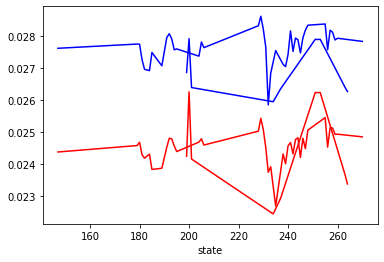

In [54]:
# WEIGHT OF THE SYNAPSES
from utils import isinoctant
from matplotlib import pyplot as plt
df3 = df12
df2 = df3
df2 = df2.groupby("state").mean()
df2[df2["time"]<70]["syn_prox_mean"].plot(color="r")
df2[df2["time"]<70]["syn_dist_mean"].plot(color="b")
df2[df2["time"]>150]["syn_prox_mean"].plot(color="r")
df2[df2["time"]>150]["syn_dist_mean"].plot(color="b")

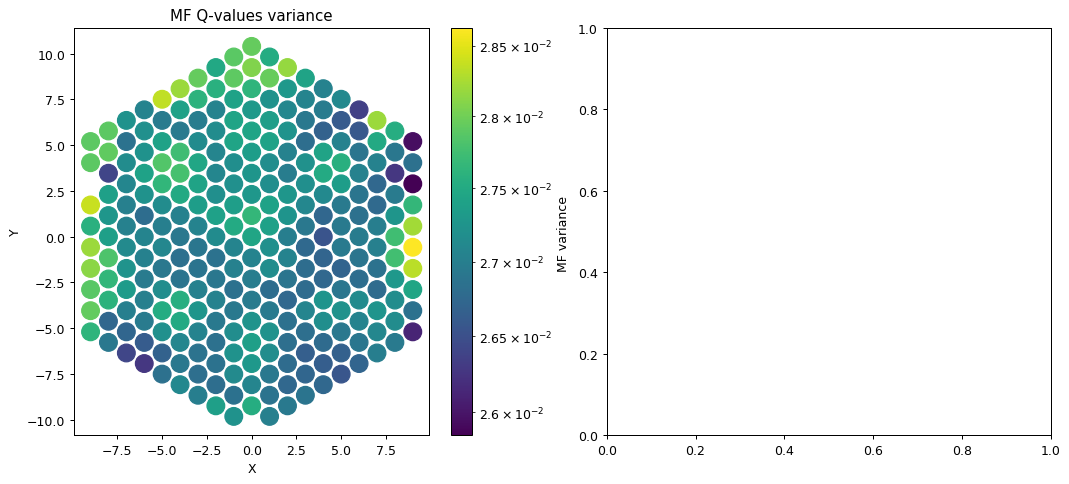

In [50]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df2["syn_dist_mean"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z,norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


In [245]:
lol = [-400.]*271
df6 = df2[df2["agent"]==2]
for i in range(len(df6)):
    lol[df6.iloc[i].state]=i

lol[90]=400
    
df6.previous_platform

2        90.0
102      90.0
202      90.0
302      90.0
402      90.0
         ... 
24602    90.0
24702    90.0
24802    90.0
24902    90.0
25002    90.0
Name: previous_platform, Length: 251, dtype: float64

In [247]:
import matplotlib
from matplotlib import pyplot as plt

def lolilol(agent):

    lol = [-400.]*271
    df6 = df2[df2["agent"]==agent]
    for i in range(len(df6)):
        lol[df6.iloc[i].state]=i

    lol[90]=400

    x = []
    y = []
    z = []
    cpt=0
    for i in range(271):
        try:
            z.append(lol[i])
            x.append(coords[i][0])
            y.append(coords[i][1])
        except:
            z.append(0)
            x.append(coords[i][0])
            y.append(coords[i][1])
            pass
        cpt+=1

    #im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
    fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

    im = axs[0].scatter(x, y, 200, c=z)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title("MF Q-values variance")
    plt.colorbar(im, label="MF variance ",ax = axs[0])


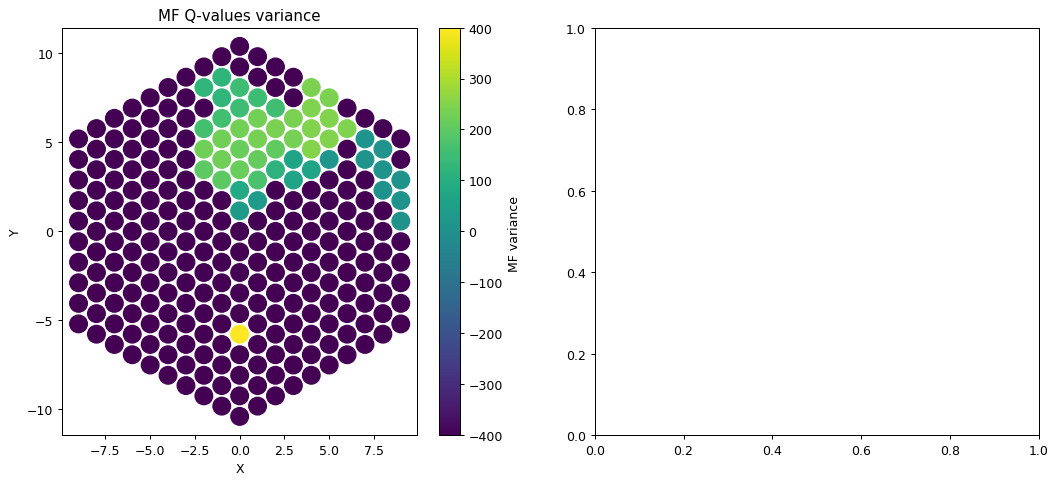

In [292]:
lolilol(51)

In [26]:
df7

index  Unnamed: 0     P(SR)  previous_platform  platform  \
state                                                               
71.72   8139.0      8139.0  0.000000               90.0       NaN   
71.81   8140.0      8140.0  0.000000               90.0       NaN   
72.30   8179.0      8179.0  0.000000               90.0       NaN   
72.82   8124.0      8124.0  0.000000               90.0       NaN   
73.28   8144.0      8144.0  0.000000               90.0       NaN   
...        ...         ...       ...                ...       ...   
147.63  7942.0      7942.0  0.000000               90.0       NaN   
167.27  7941.0      7941.0  0.000000               90.0       NaN   
188.46  7940.0      7940.0  0.000000               90.0       NaN   
219.00  7939.0      7939.0  0.000000               90.0       NaN   
249.57  7938.0      7938.0  0.460561               90.0       NaN   

        rew_func_sum     Q_max  Qsr_max  Qcombmf  Qcombsr  ...  syn_dist_mean  \
state                                                      ...                  
71.72            1.0  0.373453      0.0      1.0     0.13  ...       0.026724   
71.81            1.0  0.375236      0.0      1.0     0.16  ...       0.026719   
72.30            1.0  0.376426      0.0      1.0     0.20  ...       0.026446   
72.82            1.0  0.384712      0.0      1.0     0.25  ...       0.026840   
73.28            1.0  0.372075      0.0      1.0     0.19  ...       0.026688   
...              ...       ...      ...      ...      ...  ...            ...   
147.63           1.0  0.434974      0.0      1.0     0.13  ...       0.028219   
167.27           1.0  0.420092      0.0      1.0     0.13  ...       0.028223   
188.46           1.0  0.382937      0.0      1.0     0.15  ...       0.028218   
219.00           1.0  0.326377      0.0      1.0     0.09  ...       0.028259   
249.57           1.0  0.000000      0.0      0.0     0.00  ...       0.028259   

        trial  escape time  total trial  total time  agent  isinoctant_distal  \
state                                                                           
71.72     8.0        250.0        89.46      8139.0   49.5               0.11   
71.81     8.0        250.0        89.46      8140.0   49.5               0.16   
72.30     8.0        250.0        89.46      8179.0   49.5               0.18   
72.82     8.0        250.0        89.46      8124.0   49.5               0.16   
73.28     8.0        250.0        89.46      8144.0   49.5               0.14   
...       ...          ...          ...         ...    ...                ...   
147.63    8.0        250.0        89.46      7942.0   49.5               0.28   
167.27    8.0        250.0        89.46      7941.0   49.5               0.29   
188.46    8.0        250.0        89.46      7940.0   49.5               0.29   
219.00    8.0        250.0        89.46      7939.0   49.5               0.29   
249.57    8.0        250.0        89.46      7938.0   49.5               0.29   

        isinoctant_proximal  var_sr    var_mf  
state                                          
71.72                  0.55     0.0  0.000021  
71.81                  0.55     0.0  0.000029  
72.30                  0.52     0.0  0.000022  
72.82                  0.56     0.0  0.000033  
73.28                  0.53     0.0  0.000009  
...                     ...     ...       ...  
147.63                 0.26     0.0  0.000466  
167.27                 0.26     0.0  0.000337  
188.46                 0.26     0.0  0.000185  
219.00                 0.26     0.0  0.000066  
249.57                 0.26     0.0  0.000000  

[240 rows x 39 columns]

In [96]:
df7 = df12[np.logical_and(np.logical_or(df12["angle"]=="-180", df12["angle"]=="180"), df12["agent"]>=0)].groupby("state").mean()

In [102]:
df12

time  agent  level_0  index  Unnamed: 0  state     P(SR)  \
0         0      0     6918   6918        6918    230  0.457439   
1         0      1    19964  10695       10695    257  0.308250   
2         0      2    29562   9347        9347    257  0.363568   
3         0      3    39402   9589        9589    230  0.419254   
4         0      4    49481   8779        8779    243  0.388182   
...     ...    ...      ...    ...         ...    ...       ...   
25095   250     95   979987   5073        5073     77  0.000000   
25096   250     96   990246   5997        5997     22  0.000000   
25097   250     97  1003279   9955        9955     75  0.000000   
25098   250     98  1015653   8405        8405     19  0.000000   
25099   250     99  1028265   9900        9900     28  0.000000   

       previous_platform  platform  rew_func_sum  ...  total trial  \
0                   90.0       NaN           1.0  ...           90   
1                   90.0       NaN           1.0  ...          126   
2                   90.0       NaN           1.0  ...          126   
3                   90.0       NaN           1.0  ...          108   
4                   90.0       NaN           1.0  ...          108   
...                  ...       ...           ...  ...          ...   
25095               90.0       NaN           1.0  ...           54   
25096               90.0       NaN           1.0  ...           72   
25097               90.0       NaN           1.0  ...           54   
25098               90.0       NaN           1.0  ...           72   
25099               90.0       NaN           1.0  ...          108   

       total time  isinoctant_distal  isinoctant_proximal  proximal_posx  \
0            6918                  0                    0   0.000000e+00   
1           10695                  0                    0   0.000000e+00   
2            9347                  0                    0   0.000000e+00   
3            9589                  0                    0   0.000000e+00   
4            8779                  0                    0   0.000000e+00   
...           ...                ...                  ...            ...   
25095        5073                  0                    0   7.070502e-16   
25096        5997                  0                    0   7.070502e-16   
25097        9955                  0                    1   7.070502e-16   
25098        8405                  1                    0   7.070502e-16   
25099        9900                  0                    1   7.070502e-16   

       proximal_posy  angle  previous_coord  has_reached_prox  proximal_MF  
0          -5.773503      0             230                 0         True  
1          -5.773503      0             257                 0         True  
2          -5.773503      0             257                 0         True  
3          -5.773503      0             230                 0         True  
4          -5.773503      0             243                 0         True  
...              ...    ...             ...               ...          ...  
25095       5.773503    180              77                 0         True  
25096       5.773503    180              22                 0         True  
25097       5.773503    180              75                 0         True  
25098       5.773503    180              19                 0         True  
25099       5.773503    180              28                 0         True  

[125500 rows x 46 columns]

In [116]:
df7=df12[np.logical_and(df12["angle"]==90,df12["time"]<100)].groupby("state").mean()

In [143]:
df12[np.logical_and(df12["angle"]!=0,df12["time"]<230)].groupby("state").mean()["proximal_MF"].mean()

0.4651084870330083

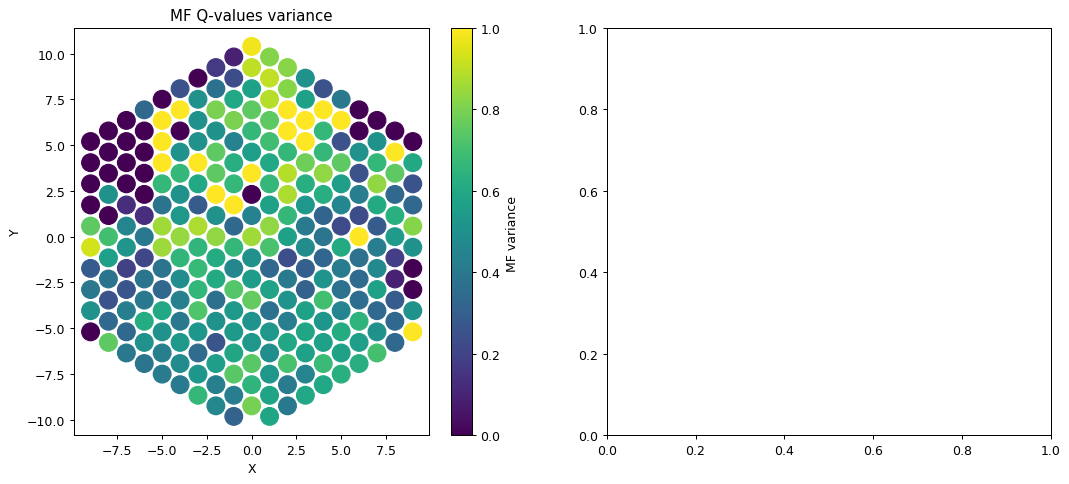

In [117]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["proximal_MF"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


In [71]:
df7

index   Unnamed: 0        time  P(SR)  previous_platform  \
state                                                                   
0      7800.863636  7800.863636  216.590909    0.0               90.0   
1      8547.555556  8547.555556  210.055556    0.0               90.0   
2      8554.785714  8554.785714  211.714286    0.0               90.0   
3      8467.520000  8467.520000  214.120000    0.0               90.0   
4      7371.642857  7371.642857  217.928571    0.0               90.0   
...            ...          ...         ...    ...                ...   
265    8130.750000  8130.750000  220.625000    0.0               90.0   
266    9143.777778  9143.777778  210.111111    0.0               90.0   
267    8334.800000  8334.800000  215.800000    0.0               90.0   
268    9192.142857  9192.142857  224.571429    0.0               90.0   
269    9959.400000  9959.400000  234.600000    0.0               90.0   

       platform  rew_func_sum     Q_max  Qsr_max  Qcombmf  ...  escape time  \
state                                                      ...                
0           NaN           1.0  0.428111      0.0      1.0  ...        250.0   
1           NaN           1.0  0.440024      0.0      1.0  ...        250.0   
2           NaN           1.0  0.442909      0.0      1.0  ...        250.0   
3           NaN           1.0  0.431810      0.0      1.0  ...        250.0   
4           NaN           1.0  0.431559      0.0      1.0  ...        250.0   
...         ...           ...       ...      ...      ...  ...          ...   
265         NaN           1.0  0.363452      0.0      1.0  ...        250.0   
266         NaN           1.0  0.351314      0.0      1.0  ...        250.0   
267         NaN           1.0  0.343929      0.0      1.0  ...        250.0   
268         NaN           1.0  0.306618      0.0      1.0  ...        250.0   
269         NaN           1.0  0.301429      0.0      1.0  ...        250.0   

       total trial   total time      agent  isinoctant_distal  \
state                                                           
0        81.000000  7800.863636  47.545455                0.0   
1        93.000000  8547.555556  53.888889                0.0   
2        85.500000  8554.785714  49.214286                0.0   
3        90.000000  8467.520000  52.040000                0.0   
4        79.714286  7371.642857  53.071429                0.0   
...            ...          ...        ...                ...   
265      99.000000  8130.750000  56.125000                0.0   
266     106.000000  9143.777778  61.888889                0.0   
267      91.800000  8334.800000  68.100000                1.0   
268      90.000000  9192.142857  75.285714                1.0   
269     108.000000  9959.400000  64.000000                1.0   

       isinoctant_proximal  var_sr    var_mf  entro_sr  entro_mf  
state                                                             
0                      0.0     0.0  0.000634       NaN  1.789668  
1                      0.0     0.0  0.000822       NaN  1.788893  
2                      0.0     0.0  0.000889       NaN  1.788952  
3                      1.0     0.0  0.001093       NaN  1.788169  
4                      0.0     0.0  0.000709       NaN  1.789365  
...                    ...     ...       ...       ...       ...  
265                    0.0     0.0  0.000484       NaN  1.789514  
266                    0.0     0.0  0.000535       NaN  1.788794  
267                    0.0     0.0  0.001052       NaN  1.785801  
268                    0.0     0.0  0.000547       NaN  1.788057  
269                    0.0     0.0  0.001368       NaN  1.782255  

[224 rows x 42 columns]

In [70]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["proximal_MF"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z,norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000015F0238D558> (for post_execute):


ValueError: values must all be positive

ValueError: values must all be positive

<Figure size 1260x540 with 3 Axes>

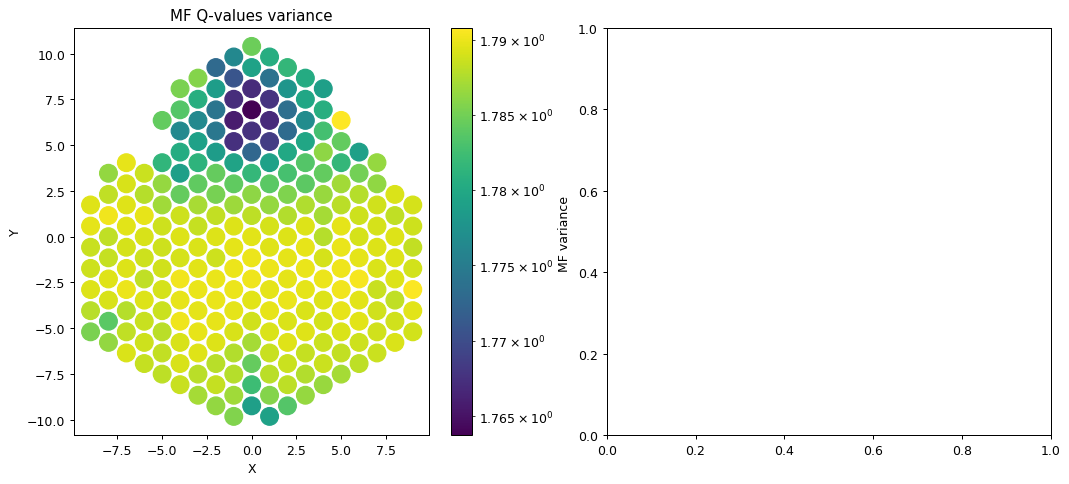

In [43]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["entro_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z,norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


In [ ]:
a = [1,2,3,4,5,6]

In [54]:
entropy([0.1,0.2,0.1,0.2,0.1,0.1])

1.7328679513998633

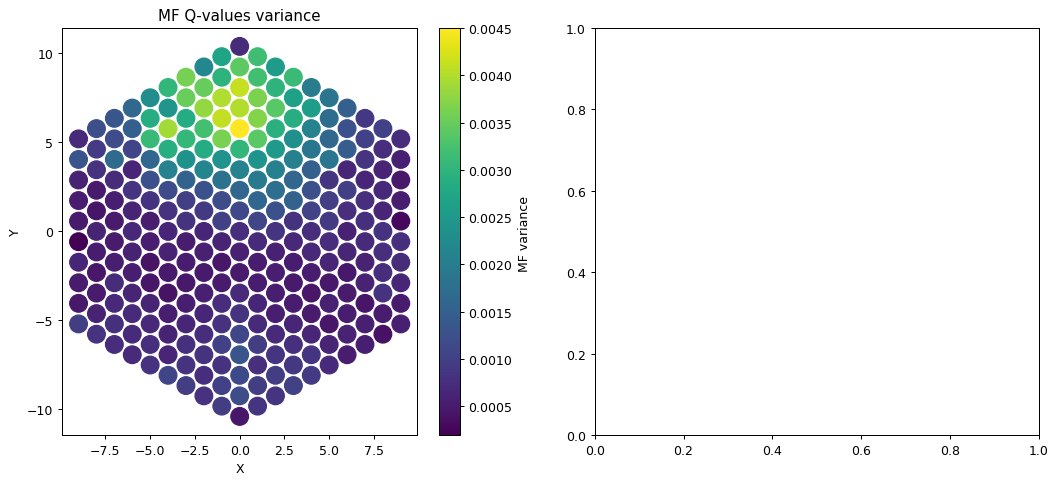

In [350]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in df7.index:
    try:
        z.append(df7["var_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z,)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


In [324]:
import scikit_posthocs as sp
sp.posthoc_ttest(df3, val_col='varsr', group_col='distance_group', p_adjust='holm')

True          False
True   1.000000e+00  3.195072e-42
False  3.195072e-42  1.000000e+00

In [252]:
df2 = df[np.logical_and(df["session"]>5, df["trial"]>-1)]
#df2 = df2[df2["platform"]==126]
df2 = df2.groupby(by=["state"]).mean().sort_values(by='state', ascending=True)
print(len(df2))

263


In [376]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaMF"], df3[df3["distance_group"]==True]["prevaMF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=77.10606462585704, pvalue=1.6201904747279406e-18)


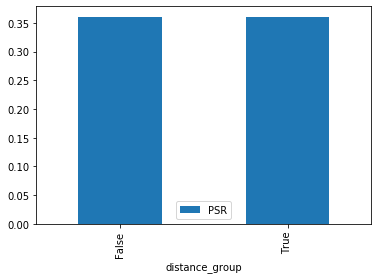

In [328]:
df3=df3.groupby(by=["distance_group"]).mean()
df3[["PSR"]].plot.bar()

In [169]:
from utils import get_coords
coords = get_coords()

In [318]:
#yolo = df2["P(SR)"].tolist()
yolo = p_sr

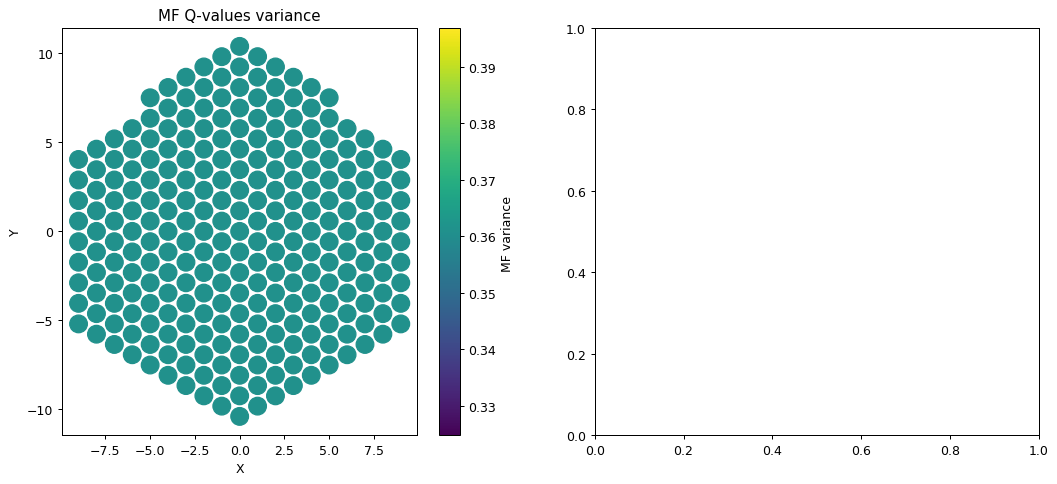

In [319]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in df2.index:
    try:
        z.append(yolo[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])


In [255]:
from utils import charge_agents
agents = charge_agents("../saved_results/"+path+"/agents.p")
for a in agents:
    a.env.set_platform_state(126)
    a.env.set_proximal_landmark()
    a.env.delete_distal_landmark()
    a.env.one_episode(a, 500)
    a.env.one_episode(a, 500)
    a.env.one_episode(a, 500)
    a.env.one_episode(a, 500)
    

In [213]:
yolo = df2["Qcombmf"].tolist()
yolo2 = df2["Qcombsr"].tolist()

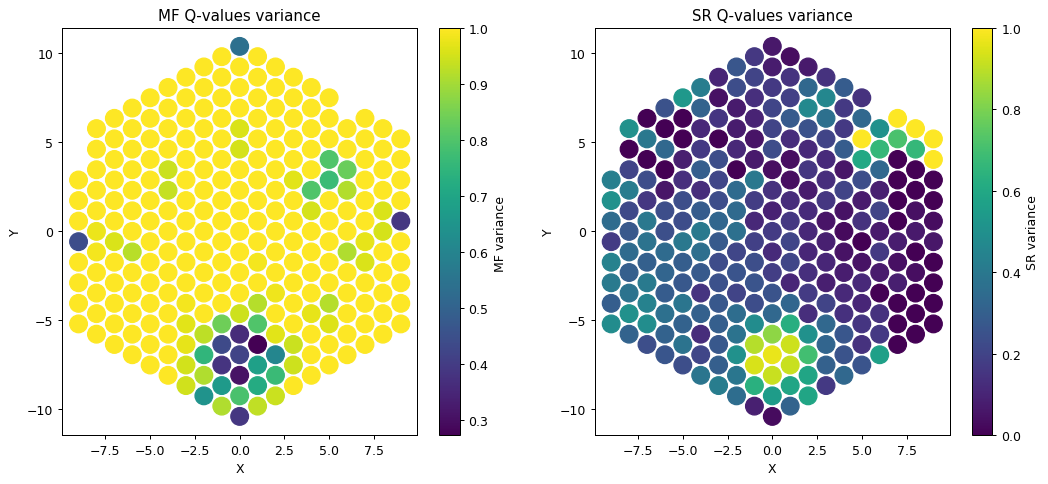

In [214]:
import matplotlib.pyplot as plt
x = []
y = []
z = []
cpt=0
for i in df2.index:
    try:
        z.append(yolo[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])

x = []
y = []
z = []
cpt=0
for i in df2.index:
    try:
        z.append(yolo2[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
#plt.figure(figsize=(7, 6), dpi=90)
im = axs[1].scatter(x, y, 200, c=z)
#ax.set_xticklabels([-100, -75, 0, 25, 0, 25, 50, 75, 100])
#ax.set_yticklabels(["lol", -100, -50, 0, 50, 100])
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("SR Q-values variance")
plt.colorbar(im, label="SR variance")

In [176]:
df["var_sr"] = df.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df["var_mf"] = df.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)

In [215]:
yolo = df2["var_mf"].tolist()
yolo2 = df2["var_sr"].tolist()

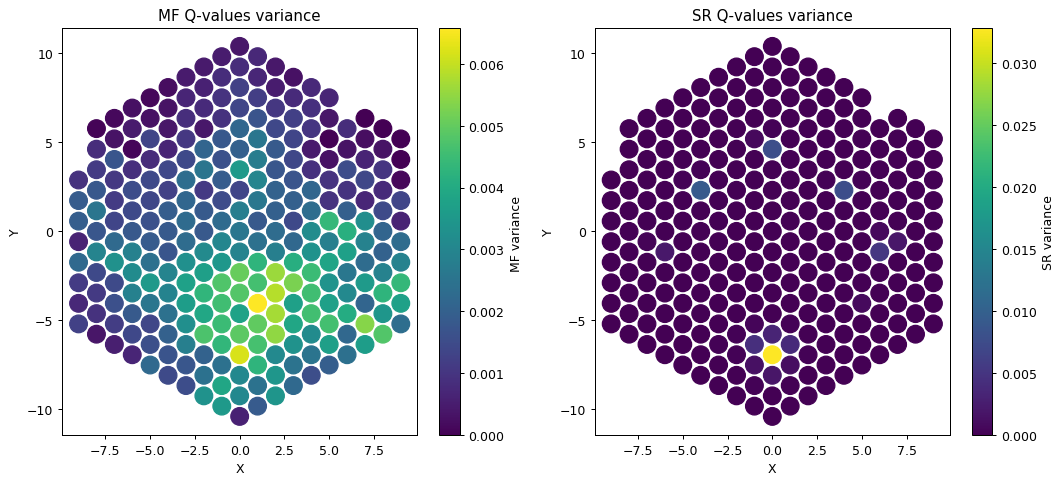

In [216]:
import matplotlib.pyplot as plt
x = []
y = []
z = []
cpt=0
for i in df2.index:
    try:
        z.append(yolo[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values variance")
plt.colorbar(im, label="MF variance ",ax = axs[0])

x = []
y = []
z = []
cpt=0
for i in df2.index:
    try:
        z.append(yolo2[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
#plt.figure(figsize=(7, 6), dpi=90)
im = axs[1].scatter(x, y, 200, c=z)
#ax.set_xticklabels([-100, -75, 0, 25, 0, 25, 50, 75, 100])
#ax.set_yticklabels(["lol", -100, -50, 0, 50, 100])
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("SR Q-values variance")
plt.colorbar(im, label="SR variance")

In [37]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [38]:
df = pd.DataFrame(data=np.random.normal(0, 1, (20, 10)))

pca = PCA(n_components=5)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

        PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0  0.302751 -0.372511  0.449007  0.087444 -0.046012 -0.383629  0.186931   
1 -0.343257  0.343345  0.223306 -0.336221 -0.320474  0.293340  0.442635   
2 -0.023313  0.341886  0.334428  0.550775 -0.111856 -0.150449  0.208436   
3  0.606789  0.201906  0.143001 -0.182486 -0.003094 -0.149453 -0.117286   
4 -0.350131 -0.103103  0.120588 -0.200440 -0.551979 -0.587068 -0.158261   
5 -0.277278  0.264231 -0.468772  0.214754  0.221074 -0.484714 -0.103611   
6  0.349625  0.399759 -0.212194 -0.241892 -0.410523  0.000894 -0.345999   
7  0.010070  0.418461  0.178123 -0.409339  0.522852 -0.340849  0.256705   
8  0.306563  0.129180 -0.406789  0.291161 -0.295297 -0.070412  0.566924   
9  0.077366 -0.391977 -0.373786 -0.381463  0.000260 -0.145181  0.411257   

        PC7       PC8       PC9  
0 -0.154083 -0.451701  0.385119  
1 -0.108968  0.032406  0.451416  
2  0.611790  0.091795 -0.077909  
3 -0.068475  0.659841  0.247204  
4 -0

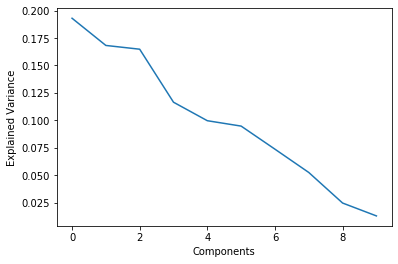

In [40]:
import pandas
from sklearn.decomposition import PCA
import numpy
import matplotlib.pyplot as plot

df = pandas.DataFrame(data=numpy.random.normal(0, 1, (20, 10)))

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pandas.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()

In [19]:
df2 = df.reset_index()
df2 = df2[np.logical_or(df2["session"]==0, df2["session"]==10)]
df2 = df2.pivot_table(index=['agent', 'session'], aggfunc='mean')
df2["PSR"] = df2[["P(SR)"]]
print(len(df2))

model = ols('PSR ~ C(session) + C(session)', data=df2.reset_index()).fit()
print()
print("Computing ANOVA on trial...")
print(sm.stats.anova_lm(model, typ=2))

200

Computing ANOVA on trial...
               sum_sq     df            F         PR(>F)
C(session)  10.952770    1.0  3372.265373  2.617132e-126
Residual     0.643084  198.0          NaN            NaN


In [7]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_sessions = 11
env_params.n_trials = 4
env_params.n_agents = 100
env_params.init_sr = "zero"
env_params.landmark_dist = 4
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.088
ag_params.q_lr = 0.1752
ag_params.inv_temp = 64
ag_params.gamma = 0.92
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.0001
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

Computing the mean performances of the agents...

Computing ANOVA on trial...
                sum_sq   df          F    PR(>F)
C(trial)  14928.838085  1.0  24.206468  0.002657
Residual   3700.375758  6.0        NaN       NaN


Computing ANOVA on session...
                 sum_sq   df          F    PR(>F)
C(session)  80300.28125  1.0  26.672896  0.002085
Residual    18063.34375  6.0        NaN       NaN

Computing the heading-vectors of each strategy...



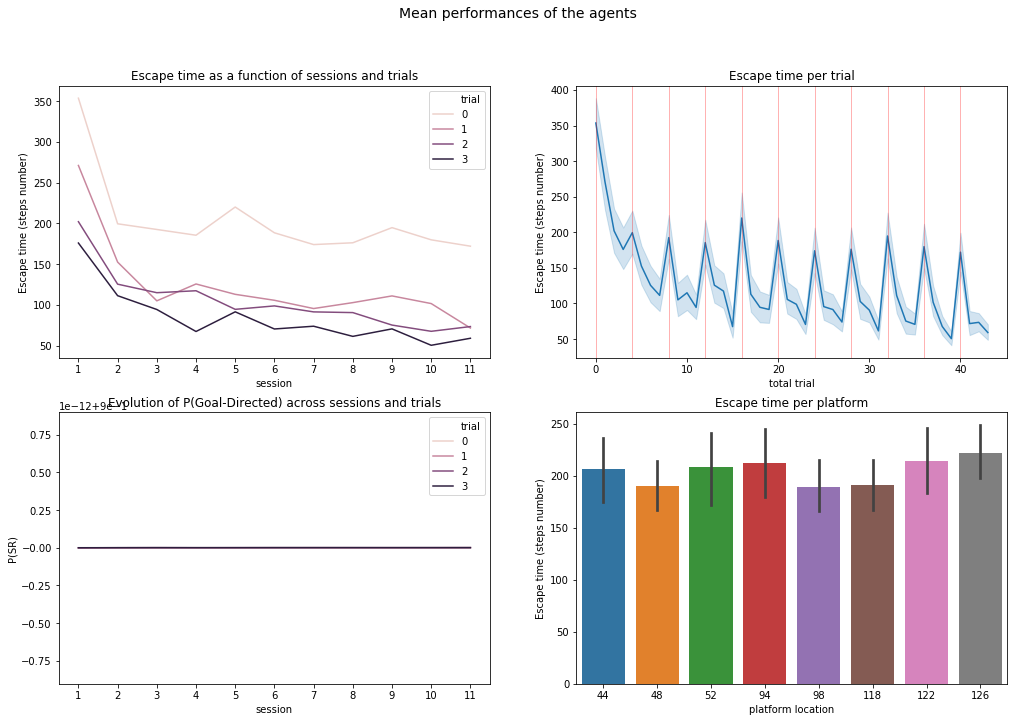

<Figure size 432x288 with 0 Axes>

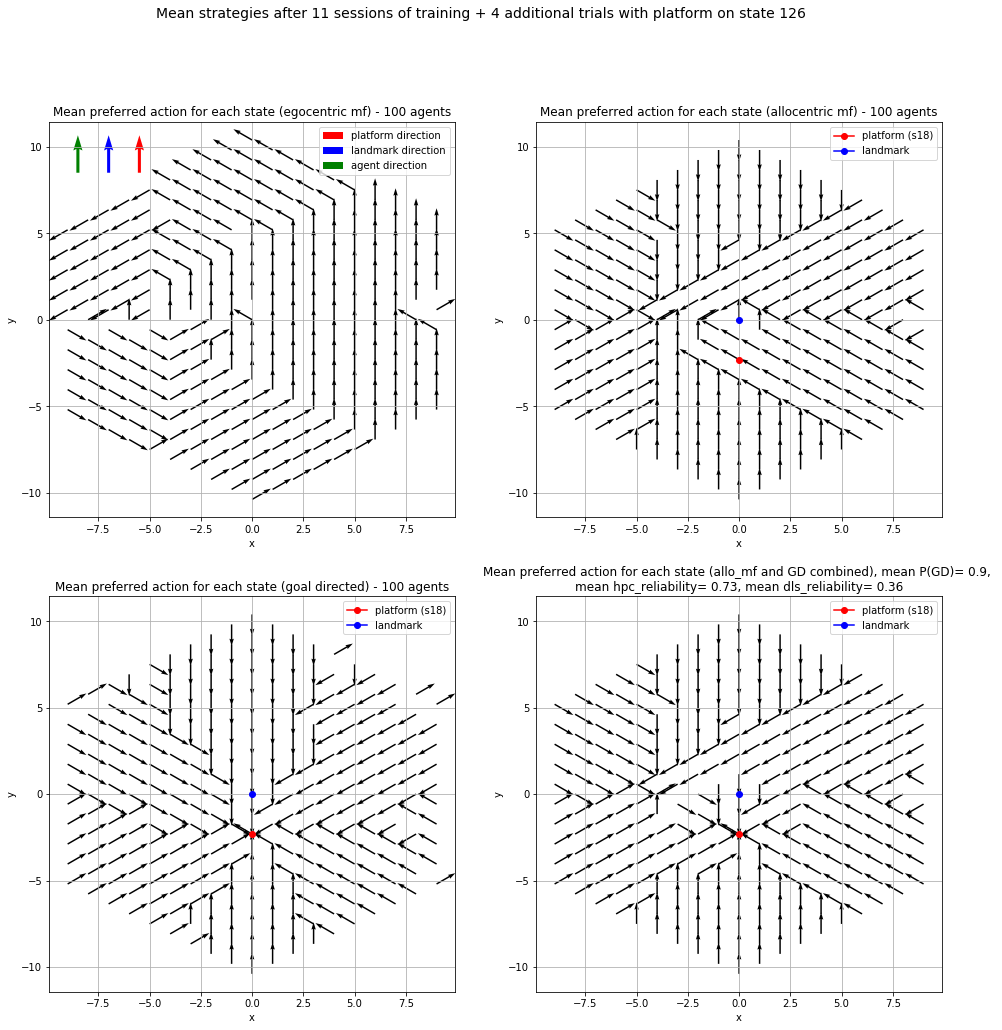

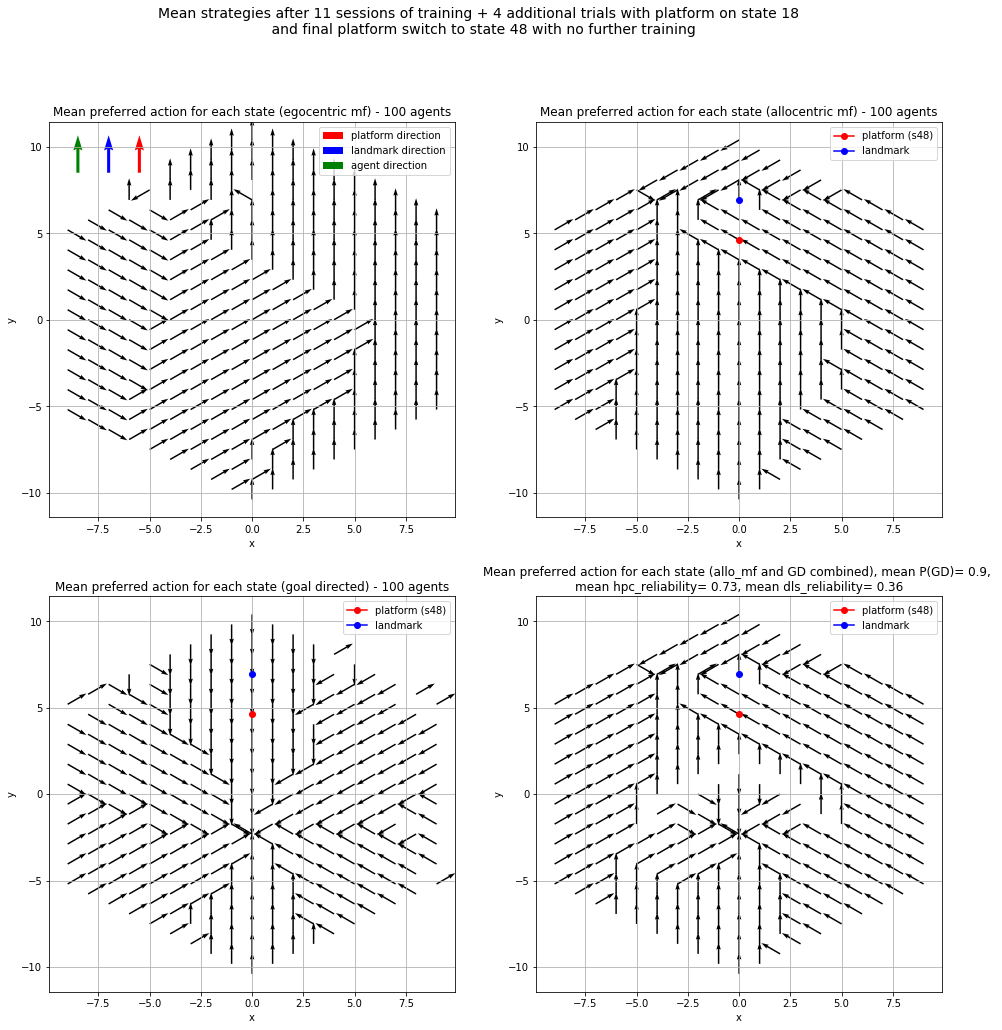

In [6]:
perform_group_pearce(env_params, ag_params)

Computing the mean performances of the agents...

Computing ANOVA on trial...
              sum_sq   df         F    PR(>F)
C(trial)   41.152135  1.0  0.528492  0.494616
Residual  467.202204  6.0       NaN       NaN


Computing ANOVA on session...
                  sum_sq   df         F    PR(>F)
C(session)  73186.102083  1.0  6.040929  0.049264
Residual    72690.241667  6.0       NaN       NaN

Computing the heading-vectors of each strategy...



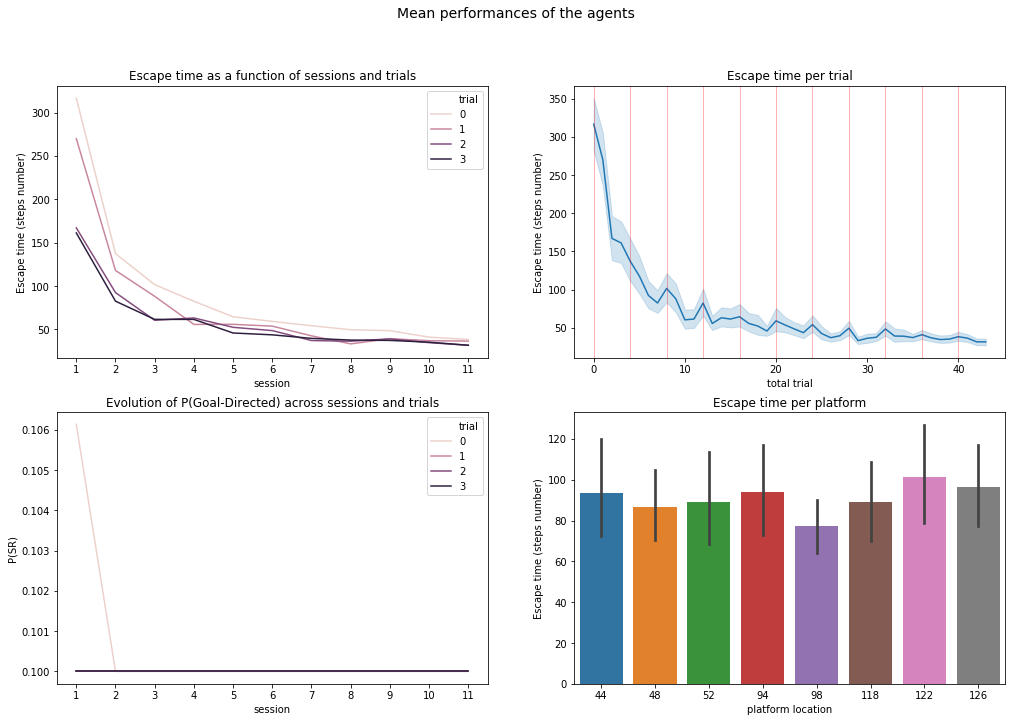

<Figure size 432x288 with 0 Axes>

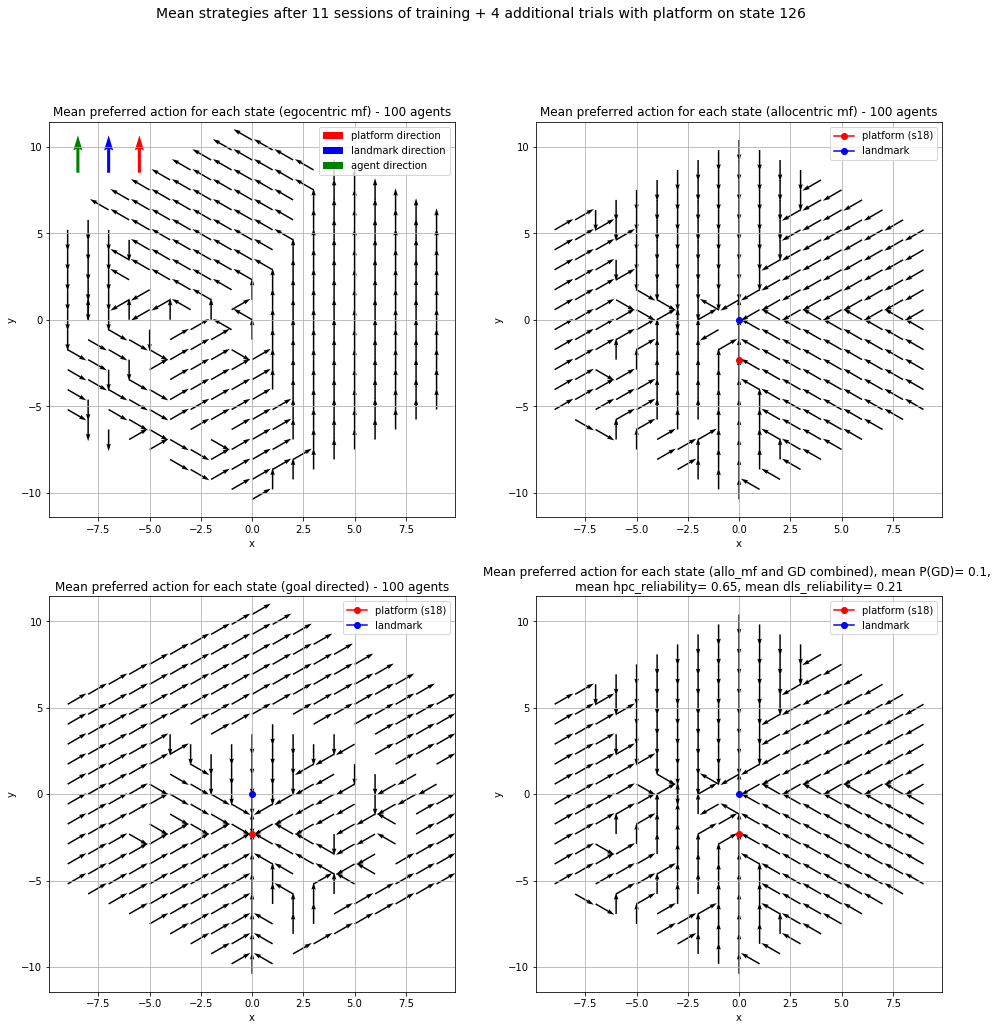

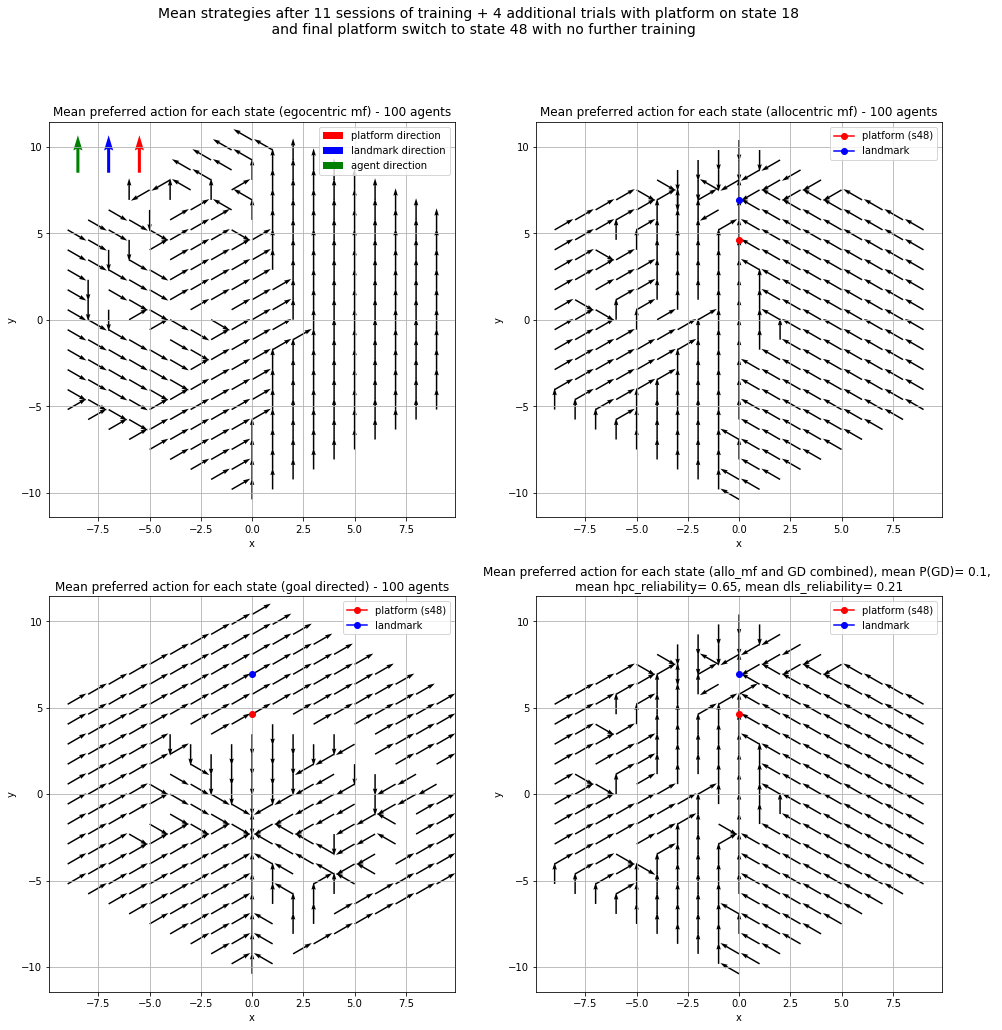

PicklingError: Can't pickle <class 'agents.fusion_agent.CombinedAgent'>: it's not the same object as agents.fusion_agent.CombinedAgent

In [8]:
perform_group_pearce(env_params, ag_params)